# **Codificando Mecanismos de Atenção**

Neste ponto, você já sabe como preparar o texto de entrada para o treinamento de LLMs, dividindo o texto em tokens individuais de palavras e subpalavras, que podem ser codificados em representações vetoriais, embeddings, para o LLM.

Agora, examinaremos uma parte integrante da própria arquitetura do LLM: os mecanismos de atenção, conforme ilustrado na Figura 3.1. Analisaremos, em grande parte, os mecanismos de atenção isoladamente e nos concentraremos neles em um nível mecanicista. Em seguida, codificaremos as partes restantes do LLM em torno do mecanismo de autoatenção para vê-lo em ação e criar um modelo para gerar texto.

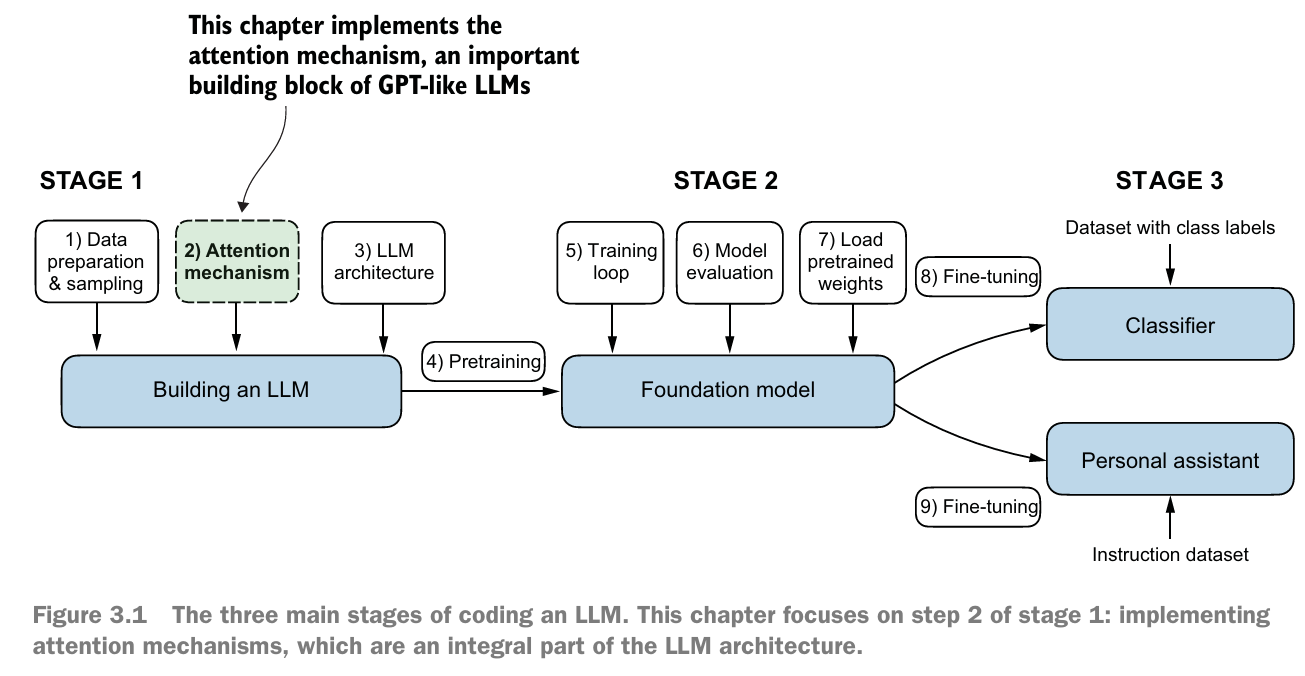

Implementaremos quatro variantes diferentes de mecanismos de atenção, conforme ilustrado na figura 3.2. Essas diferentes variantes de atenção se complementam, e o objetivo é chegar a uma implementação compacta e eficiente de atenção multicabeça, que possamos então conectar à arquitetura LLM que codificaremos no próximo capítulo.

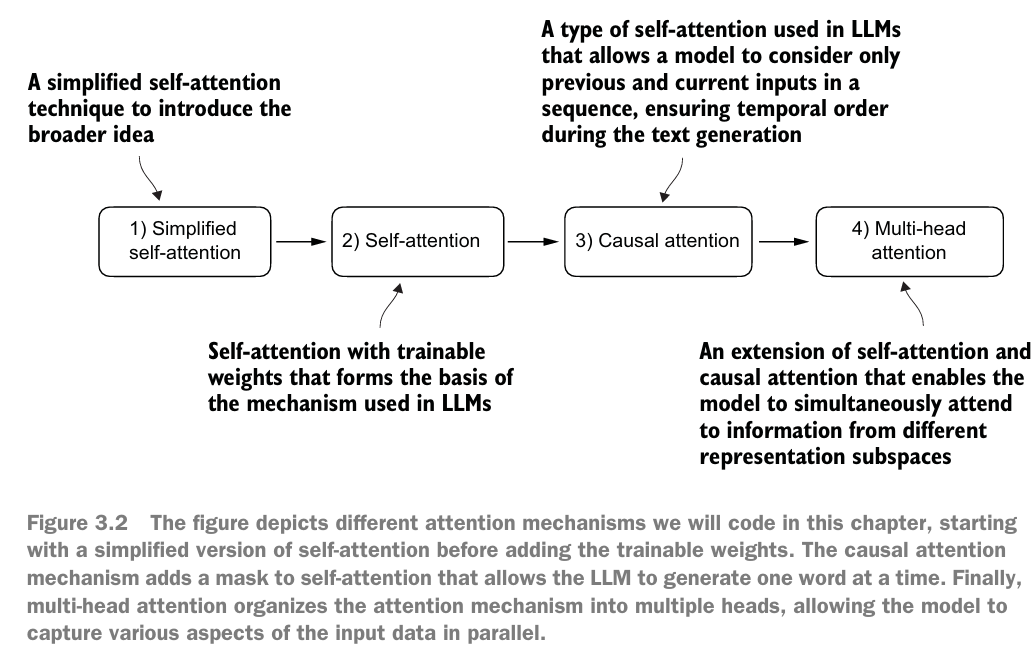

---

## **1 - O Problema com a Modelagem de Sequências Longas**

Antes de nos aprofundarmos no mecanismo de *autoatenção (self-attention)* no cerne dos LLMs, vamos considerar o problema com as arquiteturas pré-LLM que não incluem mecanismos de atenção. Suponha que queiramos desenvolver um modelo de tradução de idiomas que traduza texto de um idioma para outro. Como mostrado na figura 3.3, não podemos simplesmente traduzir um texto palavra por palavra devido às estruturas gramaticais dos idiomas de origem e de destino.

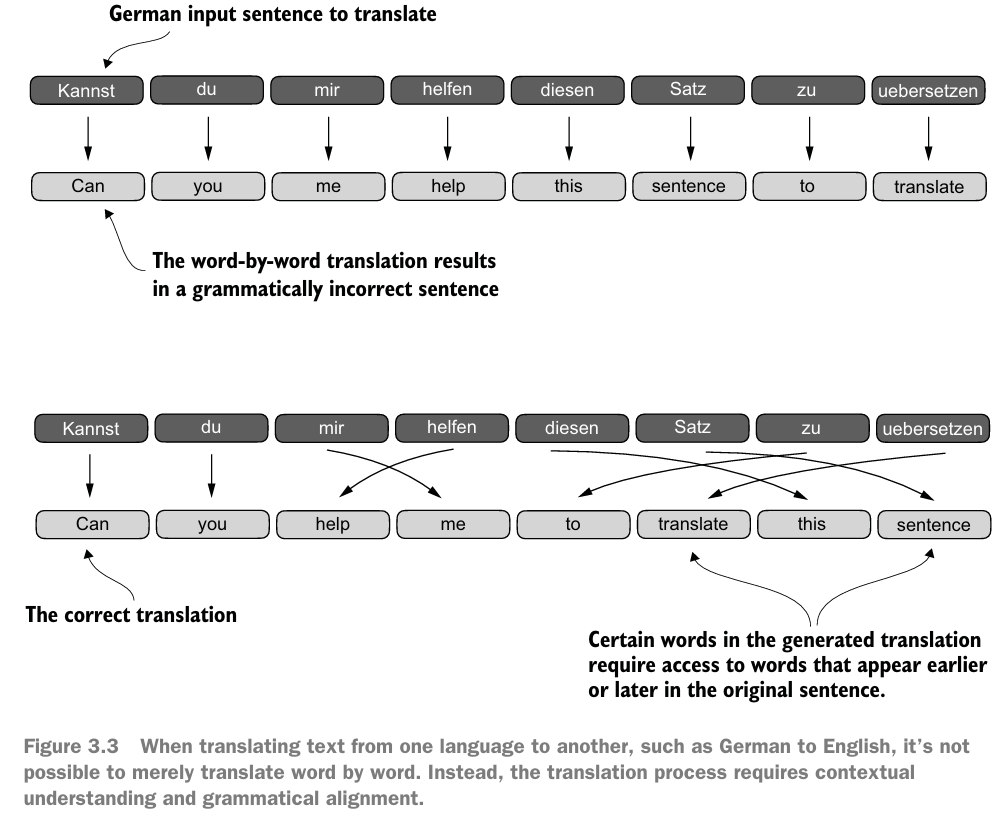

Para resolver esse problema, é comum usar uma rede neural profunda com dois submódulos, um codificador e um decodificador. A função do codificador é primeiro ler e processar todo o texto, e o decodificador então produz o texto traduzido.

Antes do advento dos transformadores, as *redes neurais recorrentes (RNNs*) eram a arquitetura de codificador-decodificador mais popular para tradução de idiomas. Uma RNN é um tipo de rede neural em que as saídas das etapas anteriores são alimentadas como entradas para a etapa atual, tornando-as adequadas para dados sequenciais, como texto. Se você não está familiarizado com RNNs, não se preocupe — você não precisa conhecer o funcionamento detalhado das RNNs para acompanhar esta discussão; nosso foco aqui é mais no conceito geral da configuração do codificador/decodificador.

Em uma RNN codificadora-decodificadora, o texto de entrada é alimentado no codificador, que o processa sequencialmente. O codificador atualiza seu estado oculto (os valores internos nas camadas ocultas) a cada etapa, tentando capturar todo o significado da frase de entrada no estado oculto final, conforme ilustrado na Figura 3.4. O decodificador então utiliza esse estado oculto final para começar a gerar a frase traduzida, uma palavra de cada vez. Ele também atualiza seu estado oculto a cada etapa, que supostamente contém o contexto necessário para a previsão da próxima palavra.

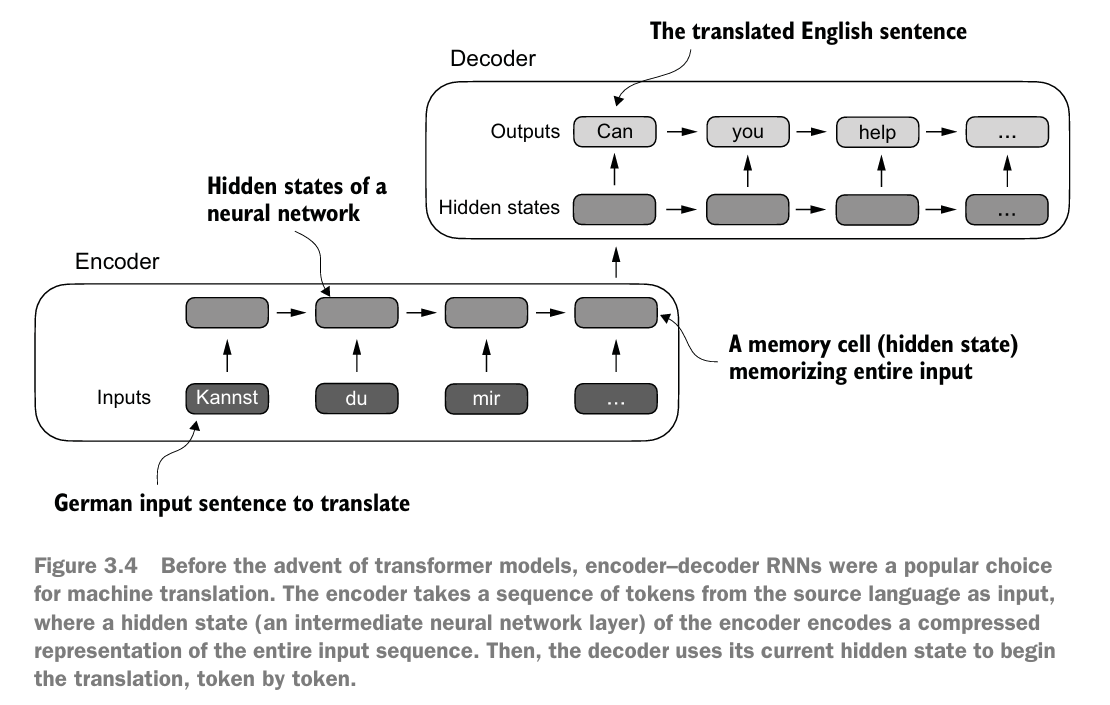

Embora não precisemos conhecer o funcionamento interno dessas RNNs codificadoras-decodificadoras, a ideia-chave aqui é que a parte codificadora processa todo o texto de entrada em um estado oculto (célula de memória). O decodificador então assume esse estado oculto para produzir a saída. Você pode pensar nesse estado oculto como um vetor de incorporação, um conceito que discutimos no capítulo 2.

A grande limitação das RNNs codificadoras-decodificadoras é que a RNN não pode acessar diretamente estados ocultos anteriores do codificador durante a fase de decodificação. Consequentemente, ela depende exclusivamente do estado oculto atual, que encapsula todas as informações relevantes. Isso pode levar à perda de contexto, especialmente em frases complexas, onde as dependências podem abranger longas distâncias.

Felizmente, não é essencial entender as RNNs para construir um LLM. Basta lembrar que as RNNs codificadoras-decodificadoras tinham uma deficiência que motivou o projeto de mecanismos de atenção.

## **2 - Capturando Dependências de Dados com Mecanismos de Atenção**

Embora as RNNs funcionem bem para traduzir frases curtas, elas não funcionam bem para textos mais longos, pois não têm acesso direto às palavras anteriores na entrada. Uma grande deficiência dessa abordagem é que a RNN precisa se lembrar de toda a entrada codificada em um único estado oculto antes de passá-la para o decodificador (figura 3.4).

Por isso, pesquisadores desenvolveram o mecanismo de atenção de *Bahdanau* para RNNs em 2014 (nomeado em homenagem ao primeiro autor do respectivo artigo; para mais informações, consulte o apêndice B), que modifica a RNN codificadora-decodificadora de forma que o decodificador possa acessar seletivamente diferentes partes da sequência de entrada em cada etapa de decodificação, conforme ilustrado na figura 3.5.

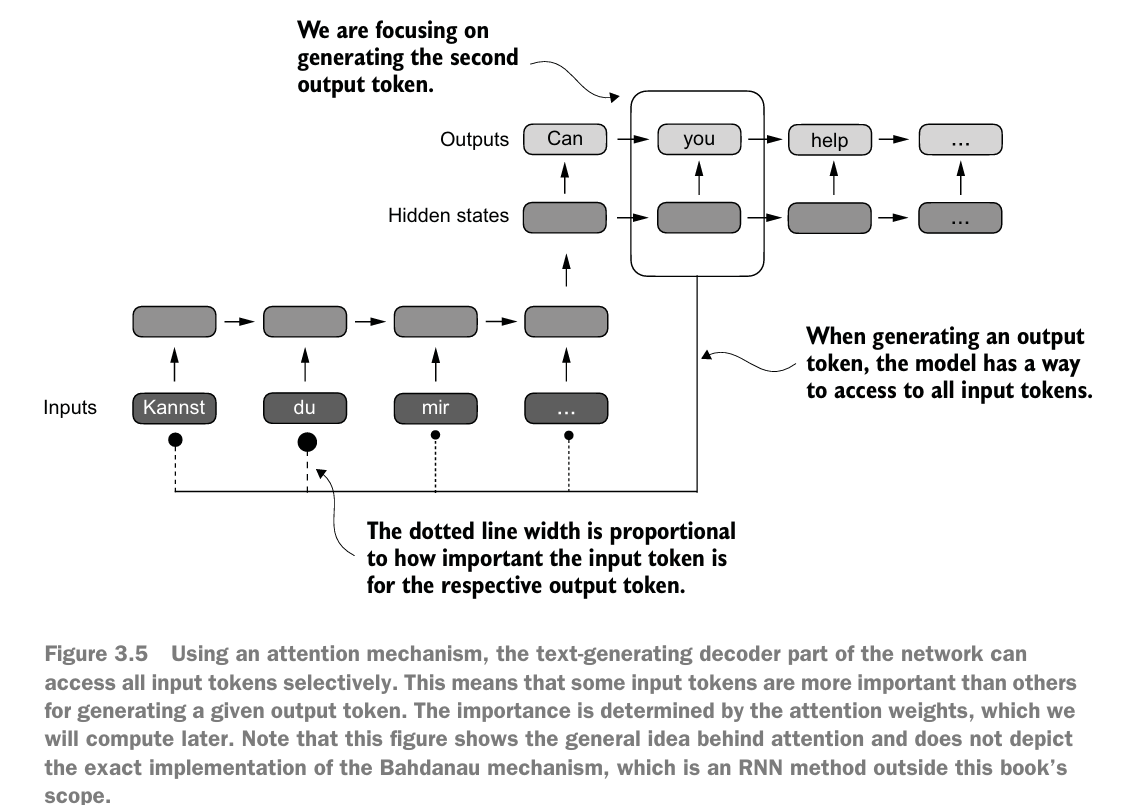

Curiosamente, apenas três anos depois, pesquisadores descobriram que arquiteturas de RNN não são necessárias para a construção de redes neurais profundas para processamento de linguagem natural e propuseram a arquitetura original do transformador (discutida no capítulo 1), incluindo um mecanismo de autoatenção inspirado no mecanismo de atenção de Bahdanau.

A autoatenção é um mecanismo que permite que cada posição na sequência de entrada considere a relevância de, ou "atenda a", todas as outras posições na mesma sequência ao calcular a representação de uma sequência. A autoatenção é um componente-chave dos LLMs contemporâneos baseados na arquitetura do transformador, como a série GPT.

Este capítulo se concentra na codificação e compreensão desse mecanismo de autoatenção usado em modelos semelhantes ao GPT, conforme ilustrado na figura 3.6. No próximo capítulo, codificaremos as partes restantes do LLM.

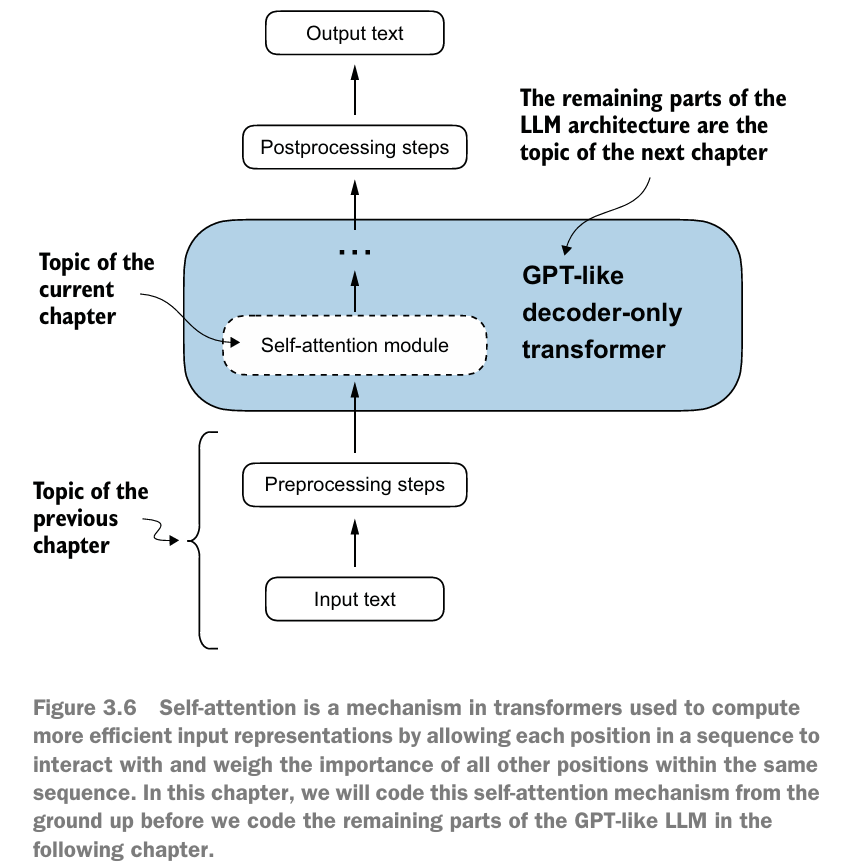

## **3 - Atender a Diferentes Partes da Entrada com Autoatenção (Self-Attention)**

Agora, abordaremos o funcionamento interno do mecanismo de autoatenção e aprenderemos como codificá-lo do zero. A autoatenção é a base de todo LLM baseado na arquitetura do transformador. Este tópico pode exigir bastante foco e atenção (sem trocadilhos), mas, depois de compreender seus fundamentos, você terá superado um dos aspectos mais difíceis deste livro e da implementação do LLM em geral.

---

$\large \textbf{O “auto” na autoatenção}$

Na autoatenção (self-attention), o "**auto (self)**" refere-se à capacidade do mecanismo de calcular pesos de atenção relacionando diferentes posições dentro de uma única sequência de entrada. Ele avalia e aprende as relações e dependências entre várias partes da própria entrada, como palavras em uma frase ou pixels em uma imagem.

Isso contrasta com os mecanismos de atenção tradicionais, onde o foco está nas relações entre elementos de duas sequências diferentes, como em modelos de sequência para sequência, onde a atenção pode estar entre uma sequência de entrada e uma sequência de saída, como no exemplo mostrado na figura 3.5.

---

Como a autoatenção pode parecer complexa, especialmente se você a estiver enfrentando pela primeira vez, começaremos examinando uma versão simplificada dela. Em seguida, implementaremos o mecanismo de autoatenção com pesos treináveis usados em LLMs.

### **3.1 - Um *Mecanismo Simples* de *Autoatenção* Sem Pesos Treináveis**

Vamos começar implementando uma variante simplificada de autoatenção, livre de pesos treináveis, conforme resumido na figura 3.7. O objetivo é ilustrar alguns conceitos-chave da autoatenção antes de adicionar pesos treináveis.

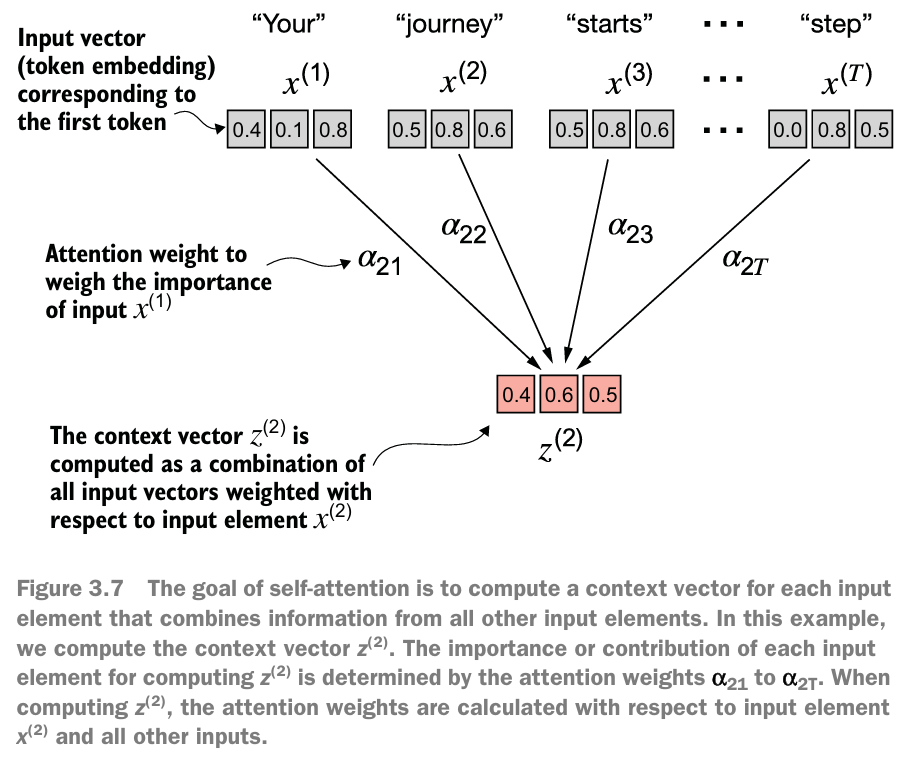

A Figura 3.7 mostra uma sequência de entrada, denotada por x, composta por $T$ elementos representados como $x^{(1)}$ a $x^{(T)}$. Essa sequência normalmente representa texto, como uma frase, que já foi transformado em embeddings de token.

Por exemplo, considere um texto de entrada como “Sua jornada começa com um passo”. Nesse caso, cada elemento da sequência, como $x^{(1)}$, corresponde a um vetor de incorporação com $d$-dimensões representando um token específico, como “Seu”. A Figura 3.7 mostra esses vetores de entrada como embeddings tridimensionais.

Na autoatenção, nosso objetivo é calcular vetores de contexto $z^{(i)}$ para cada elemento $x^{(i)}$ na sequência de entrada. Um ***vetor de contexto*** pode ser interpretado como um vetor de incorporação enriquecido.

Os vetores de contexto desempenham um papel crucial na autoatenção. Seu objetivo é criar representações enriquecidas de cada elemento em uma sequência de entrada (como uma frase), incorporando informações de todos os outros elementos da sequência (figura 3.7). Isso é essencial em LLMs, que precisam entender a relação e a relevância das palavras em uma frase entre si. Posteriormente, adicionaremos pesos treináveis que ajudarão um LLM a aprender a construir esses vetores de contexto para que sejam relevantes para que o LLM gere o próximo token. Mas primeiro, vamos implementar um mecanismo simplificado de autoatenção para calcular esses pesos e o vetor de contexto resultante, passo a passo.

Considere a seguinte frase de entrada, que já foi incorporada em vetores tridimensionais (veja o capítulo 2). Escolhi uma pequena dimensão de incorporação para garantir que ela caiba na página sem quebras de linha:

In [ ]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

O primeiro passo para implementar a autoatenção é calcular os valores intermediários $\omega$, denominados **escores de atenção (attention scores)**, conforme ilustrado na figura 3.8. Devido a restrições espaciais, a figura exibe os valores do tensor de entrada anterior em uma versão truncada; por exemplo, 0,87 é truncado para 0,8. Nessa versão truncada, as inclusões das palavras "jornada" e "início" podem parecer semelhantes por acaso.

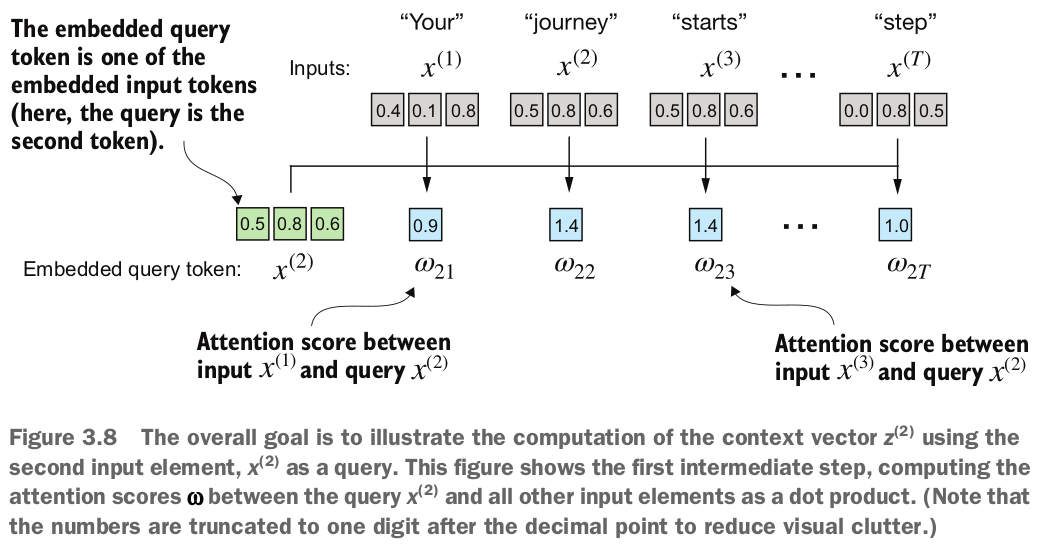

A Figura 3.8 ilustra como calculamos as pontuações intermediárias de atenção entre o token de consulta e cada token de entrada. Determinamos essas pontuações calculando o produto escalar da consulta, $x^{(2)}$, com todos os outros tokens de entrada:

In [ ]:
query = inputs[1]  # Seleciona o segundo vetor (linha com índice 1) do tensor 'inputs'.
                   # Este vetor representa o embedding do token "journey" (jornada)
                   # e será usado como o vetor de consulta para calcular as pontuações de atenção.

attn_scores_2 = torch.empty(inputs.shape[0]) # Cria um tensor vazio chamado 'attn_scores_2'.
                                             # O tamanho deste tensor é igual ao número de linhas em 'inputs' (inputs.shape[0]),
                                             # que corresponde ao número total de tokens na sequência de entrada.
                                             # Este tensor armazenará as pontuações de atenção calculadas para cada token em relação ao token de consulta.

for i, x_i in enumerate(inputs): # Inicia um loop que itera sobre cada linha (vetor) no tensor 'inputs'.
                                 # 'enumerate' retorna tanto o índice (i) quanto o valor (x_i) de cada elemento.
                                 # i: o índice da linha atual (0, 1, 2, ...)
                                 # x_i: o vetor de embedding da linha atual (cada token na sequência de entrada)

    attn_scores_2[i] = torch.dot(x_i, query) # Calcula o produto escalar (dot product) entre o vetor da linha atual (x_i)
                                             # e o vetor de consulta (query).
                                             # O produto escalar mede a similaridade entre os dois vetores.
                                             # Um produto escalar maior indica maior similaridade ou relevância entre o token atual (representado por x_i)
                                             # e o token de consulta (representado por query).
                                             # O resultado é armazenado no tensor 'attn_scores_2' na posição correspondente ao índice 'i'.
                                             # Assim, 'attn_scores_2[i]' contém a pontuação de atenção do i-ésimo token da entrada em relação ao token "jornada".

print(attn_scores_2) # Imprime o tensor 'attn_scores_2' no console.
                     # Este tensor agora contém as pontuações de atenção para cada token na sequência de entrada
                     # em relação ao token "jornada".
                     # Estas pontuações indicam o quão relevante cada token de entrada é para o token "jornada" neste contexto simplificado de atenção.

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


---

$\large \textbf{Compreendendo produtos escalares}$

Um produto escalar é essencialmente uma maneira concisa de multiplicar dois vetores elemento a elemento e depois somar os produtos, o que pode ser demonstrado da seguinte forma:

In [ ]:
res = 0.
for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


A saída confirma que a soma da multiplicação elemento a elemento fornece os mesmos resultados que o produto escalar.

Além de considerar a operação do produto escalar como uma ferramenta matemática que combina dois vetores para produzir um valor escalar, o produto escalar é uma medida de similaridade, pois quantifica o quão próximos dois vetores estão alinhados: um produto escalar maior indica um maior grau de alinhamento ou similaridade entre os vetores. No contexto dos mecanismos de autoatenção, o produto escalar determina até que ponto cada elemento em uma sequência se concentra em, ou "atende a", qualquer outro elemento: quanto maior o produto escalar, maior a similaridade e a pontuação de atenção entre os dois elementos.

---

Na próxima etapa, como mostrado na Figura 3.9, normalizamos cada uma das pontuações de atenção calculadas anteriormente. O principal objetivo da normalização é obter pesos de atenção que somam 1. Essa normalização é uma convenção útil para interpretação e manutenção da estabilidade do treinamento em um LLM. Aqui está um método simples para realizar essa etapa de normalização:

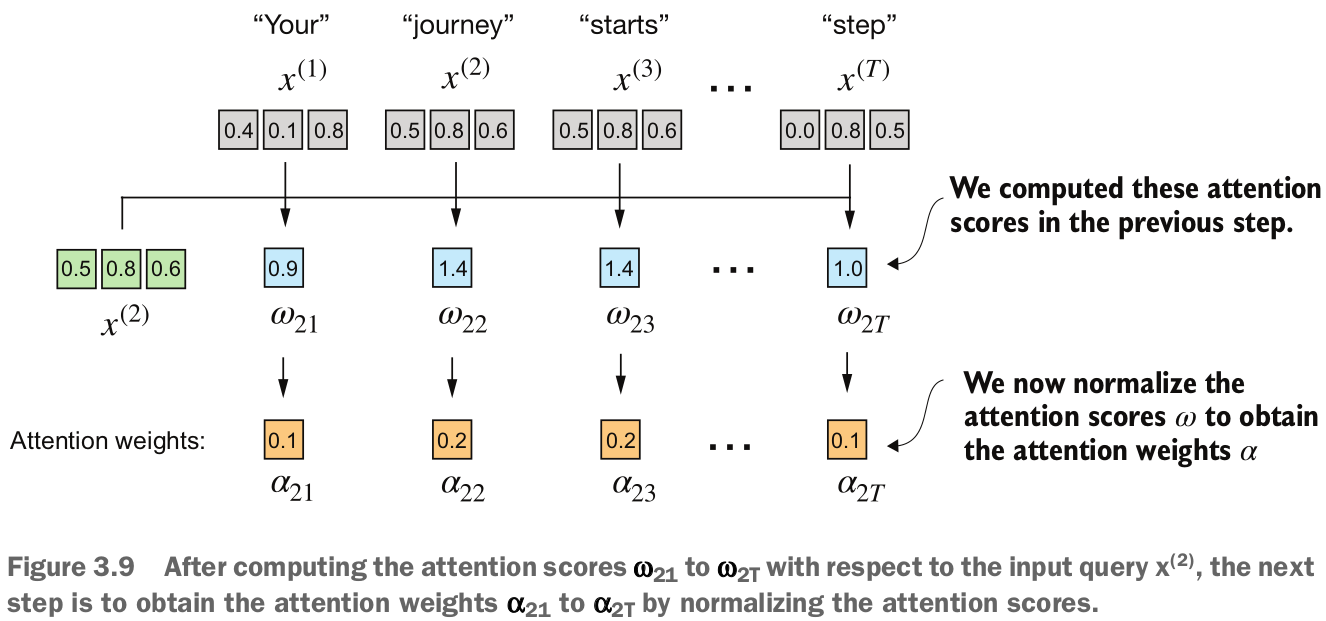

In [ ]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum() # Calcula os pesos de atenção normalizados.
                                                        # Divide cada pontuação de atenção em 'attn_scores_2'
                                                        # pela soma de todas as pontuações de atenção em 'attn_scores_2'.
                                                        # Isso garante que a soma dos 'attn_weights_2_tmp' seja 1,
                                                        # transformando as pontuações em uma distribuição de probabilidade.
                                                        # Esta é uma forma simples de normalização para este exemplo.

print("Attention weights:", attn_weights_2_tmp) # Imprime o tensor resultante 'attn_weights_2_tmp'.
                                                # Este tensor contém os pesos de atenção normalizados para cada token
                                                # da sequência de entrada em relação ao token de consulta "jornada".
                                                # Cada valor representa a importância relativa ou o quão "atencioso"
                                                # o token de consulta deve ser para o token de entrada correspondente.

print("Sum:", attn_weights_2_tmp.sum()) # Calcula e imprime a soma de todos os elementos no tensor 'attn_weights_2_tmp'.
                                        # Como a normalização foi feita dividindo pela soma total,
                                        # este valor deve ser aproximadamente igual a 1 (pode haver pequenas variações
                                        # devido à precisão de ponto flutuante).
                                        # Confirmar que a soma é 1 verifica se a normalização foi realizada corretamente.

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


Na prática, é mais comum e aconselhável usar a função softmax para normalização. Essa abordagem é mais eficaz no gerenciamento de valores extremos e oferece propriedades de gradiente mais favoráveis durante o treinamento. A seguir, uma implementação básica da função softmax para normalizar as pontuações de atenção:

In [ ]:
def softmax_naive(x): # Define uma função chamada 'softmax_naive' que recebe um tensor 'x' como entrada.
                      # Esta função implementa uma versão básica da função softmax.
    return torch.exp(x) / torch.exp(x).sum(dim=0) # Calcula a função softmax.
                                                 # torch.exp(x): Calcula o exponencial de cada elemento no tensor 'x'. Isso garante que todos os valores sejam positivos.
                                                 # torch.exp(x).sum(dim=0): Calcula a soma dos valores exponenciais ao longo da dimensão 0 (colunas, se fosse uma matriz, mas aqui é um vetor, então é a soma de todos os elementos). Este é o termo de normalização.
                                                 # A divisão: Divide cada elemento exponencial pelo termo de normalização. Isso transforma os valores em uma distribuição de probabilidade onde a soma é 1.

attn_weights_2_naive = softmax_naive(attn_scores_2) # Aplica a função 'softmax_naive' ao tensor 'attn_scores_2' (as pontuações de atenção calculadas anteriormente).
                                                    # O resultado, que são os pesos de atenção normalizados usando softmax, é armazenado na variável 'attn_weights_2_naive'.

print("Attention weights:", attn_weights_2_naive) # Imprime o tensor 'attn_weights_2_naive'.
                                                  # Este tensor contém os pesos de atenção para cada token da sequência de entrada em relação ao token de consulta "jornada", normalizados pela função softmax.
                                                  # Os valores indicam a importância relativa de cada token de entrada para o token de consulta, com a soma total sendo 1.

print("Sum:", attn_weights_2_naive.sum()) # Calcula e imprime a soma de todos os elementos no tensor 'attn_weights_2_naive'.
                                          # Como a função softmax garante que a soma de suas saídas seja 1, este valor deve ser aproximadamente 1 (pode haver pequenas diferenças devido à precisão de ponto flutuante).
                                          # Confirmar que a soma é próxima de 1 verifica se a normalização softmax foi aplicada corretamente.

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Além disso, a função softmax garante que os pesos de atenção sejam sempre positivos. Isso torna a saída interpretável como probabilidades ou importância relativa, onde pesos maiores indicam maior importância.

Observe que esta implementação ingênua do softmax (`softmax_naive`) pode encontrar problemas de instabilidade numérica, como estouro e subfluxo, ao lidar com valores de entrada grandes ou pequenos. Portanto, na prática, é aconselhável usar a implementação PyTorch do softmax, que foi amplamente otimizada para desempenho:

In [ ]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0) # Aplica a função softmax do PyTorch ao tensor 'attn_scores_2'.
                                                     # 'attn_scores_2': Este é o tensor de entrada contendo as pontuações de atenção não normalizadas.
                                                     # 'dim=0': Este parâmetro especifica a dimensão ao longo da qual a operação softmax será aplicada.
                                                     #          Neste caso, dim=0 indica que a softmax será aplicada a cada "coluna" (embora aqui seja um vetor unidimensional, então é aplicada a todos os elementos do vetor de uma vez).
                                                     #          A softmax normaliza os valores de forma que a soma de todos os elementos ao longo da dimensão especificada seja 1.
                                                     # O resultado, que são os pesos de atenção normalizados usando a implementação otimizada da softmax do PyTorch, é armazenado na variável 'attn_weights_2'.
                                                     # Estes pesos indicam a importância relativa de cada token de entrada para o token de consulta, com a soma total sendo 1.
print("Attention weights:", attn_weights_2) # Imprime o tensor 'attn_weights_2', que contém os pesos de atenção normalizados.
print("Sum:", attn_weights_2.sum()) # Calcula e imprime a soma de todos os elementos no tensor 'attn_weights_2'.
                                    # Como a função softmax garante que a soma de suas saídas ao longo da dimensão especificada seja 1, este valor deve ser aproximadamente 1 (pode haver pequenas diferenças devido à precisão de ponto flutuante).
                                    # Confirmar que a soma é próxima de 1 verifica se a normalização softmax foi aplicada corretamente.

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Agora que calculamos os pesos de atenção normalizados, estamos prontos para a
etapa final, conforme mostrado na figura 3.10: calcular o vetor de contexto $z^{(2)}$ multiplicando os tokens de entrada incorporados, $x^{(i)}$, pelos pesos de atenção correspondentes e, em seguida, somando os vetores resultantes. Assim, o vetor de contexto $z^{(2)}$ é a soma ponderada de todos os vetores de entrada, obtida pela multiplicação de cada vetor de entrada pelo seu peso de atenção correspondente:

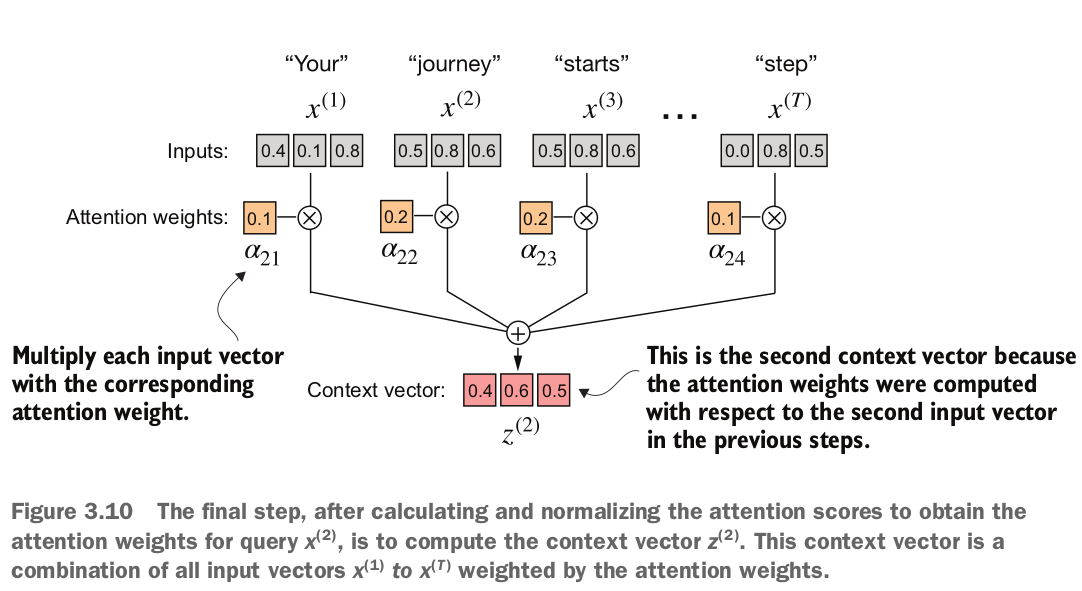

In [ ]:
query = inputs[1] # Seleciona o segundo vetor (linha com índice 1) do tensor 'inputs'.
                  # Este vetor representa o embedding do token "journey" (jornada).
                  # É usado aqui para obter a forma (dimensões) do vetor de contexto resultante,
                  # garantindo que o vetor de contexto tenha as mesmas dimensões dos embeddings de entrada.

context_vec_2 = torch.zeros(query.shape) # Cria um tensor chamado 'context_vec_2' preenchido com zeros.
                                         # O tamanho/forma deste tensor é definido pela forma do vetor 'query' (query.shape).
                                         # Este tensor 'context_vec_2' inicializará o vetor que acumulará
                                         # a soma ponderada dos vetores de entrada, resultando no vetor de contexto
                                         # para o token de consulta (neste caso, "jornada").

for i,x_i in enumerate(inputs): # Inicia um loop que itera sobre cada linha (vetor) no tensor 'inputs'.
                                 # 'enumerate' retorna tanto o índice (i) quanto o valor (x_i) de cada elemento.
                                 # i: o índice da linha atual (0, 1, 2, ...)
                                 # x_i: o vetor de embedding da linha atual (cada token na sequência de entrada)

    context_vec_2 += attn_weights_2[i]*x_i # Calcula a soma ponderada.
                                          # attn_weights_2[i]: Seleciona o peso de atenção normalizado (calculado anteriormente)
                                          # para o token de entrada atual no índice 'i' em relação ao token de consulta.
                                          # attn_weights_2[i] * x_i: Multiplica o vetor de embedding do token de entrada atual (x_i)
                                          # pelo seu peso de atenção correspondente. Isso "escala" o vetor de entrada
                                          # pela sua relevância para o token de consulta.
                                          # context_vec_2 += ...: Soma o resultado da multiplicação (o vetor de entrada escalado)
                                          # ao tensor 'context_vec_2'. Este processo é repetido para cada token de entrada,
                                          # acumulando uma soma ponderada de todos os vetores de entrada.

print(context_vec_2) # Imprime o tensor 'context_vec_2' no console.
                     # Este tensor agora contém o vetor de contexto para o token "jornada".
                     # Este vetor é uma representação enriquecida do token "jornada" que incorpora informações
                     # de todos os outros tokens na sequência de entrada, ponderadas pela sua relevância
                     # (medida pelas pontuações de atenção).
                     # Este vetor de contexto pode ser usado posteriormente em um LLM para gerar o próximo token,
                     # levando em consideração o contexto de toda a frase.

tensor([0.4419, 0.6515, 0.5683])


Em seguida, generalizaremos esse procedimento para calcular vetores de contexto simultaneamente.

### **3.2 - Calculando Pesos de Atenção Para Todos os Tokens de Entrada**

Até agora, calculamos os pesos de atenção e o vetor de contexto para a entrada 2, conforme mostrado na linha destacada na Figura 3.11. Agora, vamos estender esse cálculo para calcular os pesos de atenção e os vetores de contexto para todas as entradas.

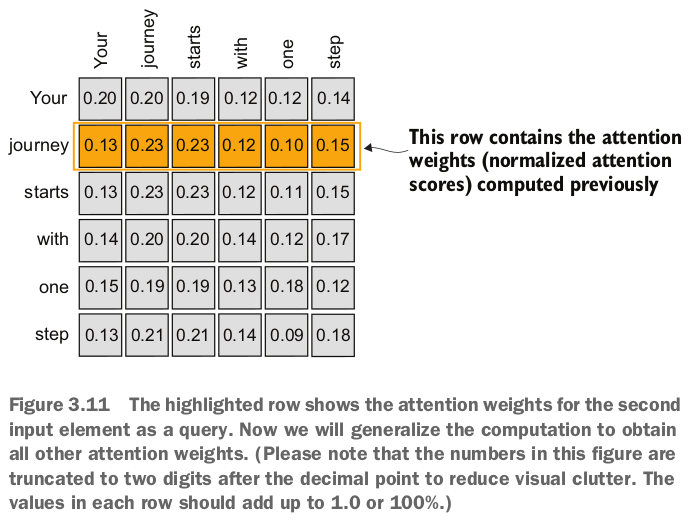

Seguimos os mesmos três passos anteriores (veja a figura 3.12), exceto que fazemos algumas modificações no código para calcular todos os vetores de contexto em vez de apenas o segundo, $z^{(2)}$:

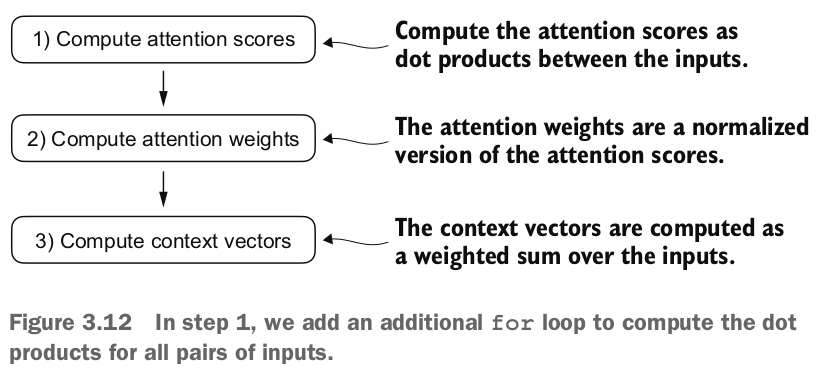

In [ ]:
attn_scores = torch.empty(6, 6) # Cria um tensor vazio chamado 'attn_scores' com dimensões 6x6.
                                # Este tensor armazenará as pontuações de atenção para cada par de tokens na sequência de entrada.
                                # A dimensão 6x6 é escolhida porque há 6 tokens na sequência de entrada ('inputs').
                                # Cada elemento attn_scores[i, j] representará a pontuação de atenção entre o i-ésimo token e o j-ésimo token.

for i, x_i in enumerate(inputs): # Inicia o loop externo. Itera sobre cada linha (vetor) no tensor 'inputs'.
                                 # 'enumerate' retorna tanto o índice (i) quanto o valor (x_i) de cada elemento.
                                 # i: o índice da linha atual (0, 1, 2, ...) representando o token "de consulta".
                                 # x_i: o vetor de embedding da linha atual, atuando como o vetor "de consulta" para esta iteração.

    for j, x_j in enumerate(inputs): # Inicia o loop interno. Itera novamente sobre cada linha (vetor) no tensor 'inputs'.
                                     # 'enumerate' retorna tanto o índice (j) quanto o valor (x_j) de cada elemento.
                                     # j: o índice da linha atual (0, 1, 2, ...) representando o token "chave".
                                     # x_j: o vetor de embedding da linha atual, atuando como o vetor "chave" para esta iteração.
                                     # Este loop interno calcula a pontuação de atenção do token de consulta (x_i)
                                     # com CADA token na sequência de entrada (x_j).

        attn_scores[i, j] = torch.dot(x_i, x_j) # Calcula o produto escalar (dot product) entre o vetor de consulta (x_i)
                                                 # e o vetor chave (x_j).
                                                 # O produto escalar mede a similaridade entre os dois vetores.
                                                 # Um produto escalar maior indica maior similaridade ou relevância entre o token de consulta (representado por x_i)
                                                 # e o token chave (representado por x_j).
                                                 # O resultado é armazenado na matriz 'attn_scores' na posição [i, j].
                                                 # Assim, attn_scores[i, j] contém a pontuação de atenção do i-ésimo token
                                                 # da entrada em relação ao j-ésimo token da entrada.

print(attn_scores) # Imprime o tensor 'attn_scores' no console.
                   # Esta matriz 6x6 contém as pontuações de atenção de cada token da sequência
                   # em relação a todos os outros tokens (incluindo ele mesmo).
                   # A linha 'i' da matriz mostra o quão relevante cada token na sequência (colunas j) é para o token 'i'.
                   # Esta matriz é um passo intermediário crucial no cálculo da autoatenção,
                   # pois quantifica as inter-relações entre todos os tokens na sequência de entrada.

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


Cada elemento no tensor representa uma pontuação de atenção entre cada par de entradas, como vimos na figura 3.11. Observe que os valores nessa figura são normalizados, e é por isso que eles diferem das pontuações de atenção não normalizadas no tensor anterior. Cuidaremos da normalização posteriormente.

Ao calcular o tensor de pontuação de atenção anterior, usamos laços for em
Python. No entanto, laços for geralmente são lentos, e podemos obter os mesmos resultados usando multiplicação de matrizes:

In [ ]:
attn_scores = inputs @ inputs.T # Calcula a matriz de pontuações de atenção usando multiplicação de matrizes.
                                 # 'inputs': Este é o tensor de entrada contendo os embeddings de cada token (formato: [número de tokens, dimensão do embedding]).
                                 # 'inputs.T': Calcula a transposta do tensor 'inputs'. Isso troca as dimensões, resultando em um tensor com formato [dimensão do embedding, número de tokens].
                                 # '@': Este operador realiza a multiplicação de matrizes entre 'inputs' e sua transposta.
                                 # O resultado é uma matriz onde cada elemento [i, j] é o produto escalar do i-ésimo vetor de entrada (linha i de 'inputs') pelo j-ésimo vetor de entrada (coluna j de 'inputs.T', que é a linha j de 'inputs').
                                 # Este produto escalar representa a pontuação de atenção entre o i-ésimo token e o j-ésimo token, medindo sua similaridade.
                                 # A matriz resultante 'attn_scores' tem o formato [número de tokens, número de tokens], onde cada linha representa as pontuações de atenção de um token de consulta em relação a todos os outros tokens.

print(attn_scores) # Imprime a matriz de pontuações de atenção calculada.
                   # Cada linha desta matriz mostra o quão "atencioso" (similar) o token correspondente (índice da linha) deve ser a todos os outros tokens (índices das colunas) na sequência de entrada.
                   # Esta matriz é o resultado eficiente da mesma operação realizada pelo loop aninhado anterior, mas otimizada para operações de tensor no PyTorch.

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


Na etapa 2 da figura 3.12, normalizamos cada linha para que os valores em cada linha somem 1.

Isso retorna o seguinte tensor de peso de atenção que corresponde aos valores mostrados na figura 3.10:

In [ ]:
attn_weights = torch.softmax(attn_scores, dim=-1) # Aplica a função softmax do PyTorch para normalizar as pontuações de atenção.
                                                  # 'attn_scores': O tensor de pontuações de atenção não normalizadas (calculado pela multiplicação de matrizes inputs @ inputs.T).
                                                  # 'dim=-1': Especifica que a normalização softmax deve ser aplicada ao longo da última dimensão do tensor 'attn_scores'.
                                                  #           Se 'attn_scores' for uma matriz (como neste caso, 6x6), 'dim=-1' refere-se às colunas.
                                                  #           Isso significa que a soma dos valores em cada linha do tensor resultante 'attn_weights' será 1.
                                                  # O resultado é um tensor chamado 'attn_weights' contendo os pesos de atenção normalizados.
                                                  # Cada elemento 'attn_weights[i, j]' representa a importância relativa do j-ésimo token para o i-ésimo token,
                                                  # após a normalização garantir que a soma das importâncias para cada token de consulta (cada linha) seja 1.
print(attn_weights) # Imprime o tensor 'attn_weights'.
                    # Esta matriz mostra os pesos de atenção normalizados.
                    # A linha 'i' exibe como o i-ésimo token "atende" (distribui sua atenção) entre todos os tokens na sequência (colunas j).
                    # Valores maiores indicam maior foco ou relevância. Por exemplo, um valor alto em attn_weights[i, j] significa que o token 'i' considera o token 'j' muito importante.

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


No contexto do uso do PyTorch, o parâmetro dim em funções como `torch.softmax`
especifica a dimensão do tensor de entrada ao longo da qual a função será computada. Ao definir `dim=-1`, estamos instruindo a função `softmax` a aplicar a normalização ao longo da última dimensão do tensor `attn_scores`. Se `attn_scores` for um tensor bidimensional (por exemplo, com o formato $\textbf{[linhas, colunas]}$), ele será normalizado nas colunas de modo que os valores em cada linha (somando a dimensão da coluna) somem 1.

Podemos verificar se a soma de todas as linhas é de fato 1:

In [ ]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581]) # Calcula a soma dos valores em uma lista predefinida.
                                                                   # Esta lista contém os pesos de atenção normalizados para a segunda linha (índice 1) do tensor 'attn_weights' calculado anteriormente.
                                                                   # É uma forma manual de verificar a soma de uma linha específica para fins de demonstração.
print("Row 2 sum:", row_2_sum) # Imprime a soma calculada manualmente para a "linha 2".

print("All row sums:", attn_weights.sum(dim=-1)) # Calcula e imprime a soma de cada linha do tensor 'attn_weights' usando a função sum do PyTorch.
                                                 # 'attn_weights': O tensor de pesos de atenção normalizados.
                                                 # 'dim=-1': Especifica que a soma deve ser calculada ao longo da última dimensão (colunas).
                                                 #           Isso resulta em um novo tensor onde cada elemento é a soma de uma linha correspondente no tensor 'attn_weights'.
                                                 #           Como 'attn_weights' foi normalizado com softmax ao longo das colunas (dim=-1), cada uma dessas somas deve ser aproximadamente 1.
                                                 #           Este comando verifica se a normalização foi aplicada corretamente a todas as linhas do tensor.

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Na terceira e última etapa da Figura 3.12, usamos esses pesos de atenção para calcular todos os vetores de contexto por meio da multiplicação de matrizes.

No tensor de saída resultante, cada linha contém um vetor de contexto tridimensional:

In [ ]:
all_context_vecs = attn_weights @ inputs # Calcula a matriz de vetores de contexto para todos os tokens de entrada usando multiplicação de matrizes.
                                        # 'attn_weights': Este é o tensor de pesos de atenção normalizados (formato: [número de tokens, número de tokens]),
                                        #               onde cada linha indica a importância de todos os outros tokens para um token de consulta específico.
                                        # 'inputs': Este é o tensor de entrada original contendo os embeddings de cada token (formato: [número de tokens, dimensão do embedding]).
                                        # '@': Este operador realiza a multiplicação de matrizes entre 'attn_weights' e 'inputs'.
                                        # O resultado é uma nova matriz 'all_context_vecs' (formato: [número de tokens, dimensão do embedding]),
                                        # onde cada linha é o vetor de contexto para o token de entrada correspondente (índice da linha).
                                        # Cada vetor de contexto é uma soma ponderada de todos os vetores de entrada,
                                        # com os pesos determinados pela matriz de pesos de atenção.
                                        # Esta operação combina as informações de todos os tokens na sequência para criar uma representação enriquecida para cada token.

print(all_context_vecs) # Imprime a matriz 'all_context_vecs' no console.
                        # Cada linha desta matriz é um vetor de contexto para um token de entrada.
                        # Por exemplo, a primeira linha é o vetor de contexto para o primeiro token ("Your"), a segunda linha para o segundo token ("journey"), e assim por diante.
                        # Estes vetores de contexto incorporam informações de toda a sequência de entrada,
                        # ponderadas pela relevância (pesos de atenção), permitindo que um LLM entenda o contexto de cada token na frase.

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


Podemos verificar novamente se o código está correto comparando a segunda linha com o vetor de contexto $z^{(2)}$ que calculamos na seção 3.3.1.

Com base no resultado, podemos ver que o `context_vec_2` calculado anteriormente corresponde exatamente à segunda linha do tensor anterior:

In [ ]:
print("Previous 2nd context vector:", context_vec_2,
      "\n2nd context vector from all_context_vecs:", all_context_vecs[1])

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683]) 
2nd context vector from all_context_vecs: tensor([0.4419, 0.6515, 0.5683])


Isso conclui o tutorial de código de um mecanismo simples de autoatenção. Em seguida, adicionaremos pesos treináveis, permitindo que o LLM aprenda com os dados e melhore seu desempenho em tarefas específicas.

## **4 - Implementando Autoatenção (Self-attention) com pesos treináveis**

Nosso próximo passo será implementar o mecanismo de autoatenção usado na arquitetura original do transformador, nos modelos GPT e na maioria dos outros LLMs populares. Esse mecanismo de autoatenção também é chamado de *atenção por produto escalar*. A Figura 3.13 mostra como esse mecanismo de autoatenção se encaixa no contexto mais amplo da implementação de um LLM.

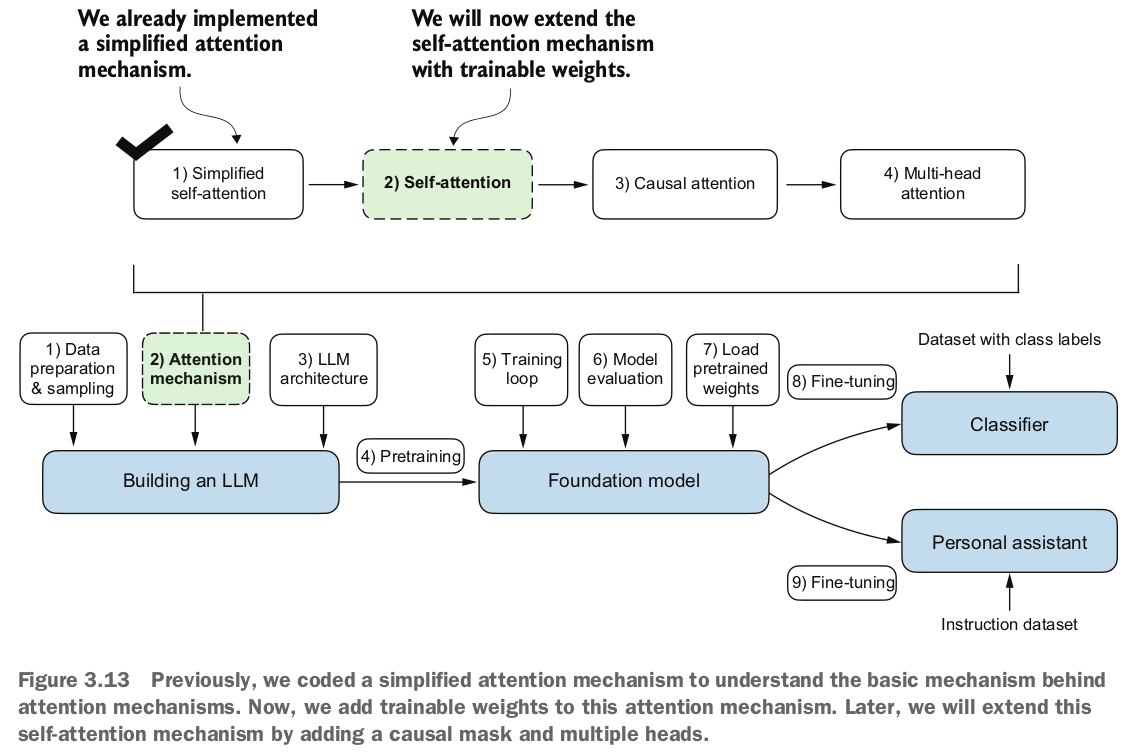

Conforme ilustrado na Figura 3.13, o mecanismo de autoatenção com pesos treináveis baseia-se nos conceitos anteriores: queremos calcular vetores de contexto como somas ponderadas sobre os vetores de entrada específicos para um determinado elemento de entrada. Como você verá, há apenas pequenas diferenças em comparação com o mecanismo básico de autoatenção que codificamos anteriormente.

A diferença mais notável é a introdução de matrizes de pesos que são atualizadas durante o treinamento do modelo. Essas matrizes de pesos treináveis são cruciais para que o modelo (especificamente, o módulo de atenção dentro do modelo) possa aprender a produzir vetores de contexto "bons". (Treinaremos o LLM no Capítulo 5.)

Abordaremos esse mecanismo de autoatenção nas duas subseções. Primeiro, o codificaremos passo a passo, como antes. Segundo, organizaremos o código em uma classe Python compacta que pode ser importada para a arquitetura do LLM.

### **4.1 - Calculando os Pesos de Atenção Passo a Passo**

Implementaremos o mecanismo de autoatenção passo a passo, introduzindo as
três matrizes de peso treináveis $W_q$, $W_k$ e $W_v$. Essas três matrizes são usadas para projetar os tokens de entrada incorporados, $x_{(i)}$, nos vetores de consulta, chave e valor, respectivamente, conforme ilustrado na Figura 3.14.

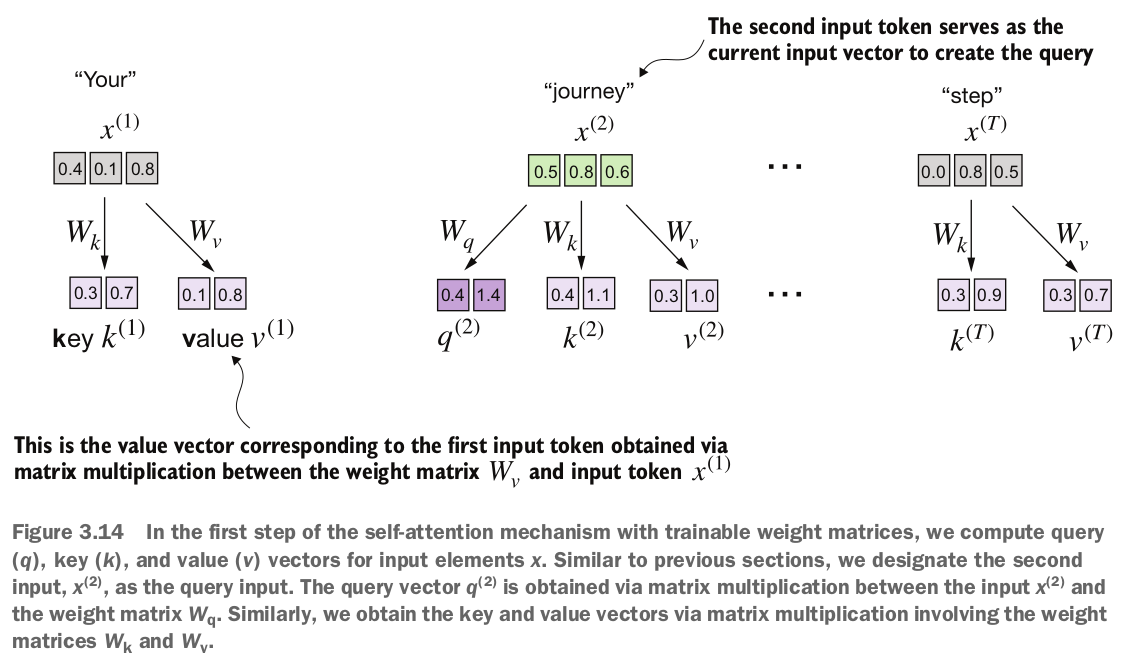

Anteriormente, definimos o segundo elemento de entrada $x^{(2)}$ como a consulta quando calculamos os
pesos de atenção simplificados para calcular o vetor de contexto $z^{(2)}$. Em seguida, generalizamos isso para calcular todos os vetores de contexto $z^{(1)}$ ... $z^{(T)}$ para a frase de entrada de seis palavras "Sua jornada começa com um passo".

Da mesma forma, começamos aqui calculando apenas um vetor de contexto, $z^{(2)}$, para fins ilustrativos. Em seguida, modificaremos este código para calcular todos os vetores de contexto.

Vamos começar definindo algumas variáveis:

In [ ]:
x_2 = inputs[1] # Seleciona o segundo vetor (linha com índice 1) do tensor 'inputs'.
                # Este vetor representa o embedding do token "journey" (jornada) na sequência de entrada.
                # Ele será usado como base para calcular o vetor de consulta (query) específico para este token.

d_in = inputs.shape[1] # Obtém a dimensão de entrada dos embeddings.
                       # 'inputs.shape' retorna uma tupla representando as dimensões do tensor 'inputs'.
                       # inputs.shape[0] é o número de linhas (tokens), e inputs.shape[1] é o número de colunas (dimensão do embedding).
                       # d_in armazenará a dimensão de cada vetor de embedding de entrada, que é 3 neste caso.

d_out = 2 # Define a dimensão de saída desejada para os vetores de consulta (query), chave (key) e valor (value).
          # Neste exemplo, estamos reduzindo a dimensão dos embeddings de 3 para 2.
          # Em LLMs reais, a dimensão de entrada e saída para query, key e value geralmente é a mesma,
          # mas é definida de forma diferente aqui para fins didáticos e para ilustrar a projeção.

Observe que, em modelos do tipo GPT, as dimensões de entrada e saída geralmente são as mesmas, mas para melhor acompanhar o cálculo, usaremos dimensões de entrada (`d_in=3`) e saída (`d_out=2`) diferentes aqui.

Em seguida, inicializamos as três matrizes de pesos $W_q$, $W_k$ e $W_v$ mostradas na figura 3.14:

In [ ]:
torch.manual_seed(123) # Define a semente para o gerador de números aleatórios do PyTorch.
                       # Isso garante que a inicialização dos pesos (nas linhas seguintes)
                       # seja a mesma toda vez que o código for executado com esta semente.
                       # É útil para reprodutibilidade, garantindo que os resultados sejam consistentes para depuração e comparação.

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
# Cria a matriz de pesos para a "query" (consulta).
# torch.nn.Parameter: Envolve um tensor para que ele seja considerado um parâmetro do modelo.
#                     Parâmetros são tensores cujos valores são atualizados durante o treinamento (se requires_grad=True).
# torch.rand(d_in, d_out): Cria um tensor (matriz) com dimensões d_in (linhas) por d_out (colunas)
#                          preenchido com números aleatórios uniformemente distribuídos entre 0 e 1.
#                          d_in é a dimensão dos embeddings de entrada (3 neste caso).
#                          d_out é a dimensão desejada para os vetores de query (2 neste caso).
#                          Esta matriz será usada para projetar o vetor de entrada (d_in) em um vetor de query (d_out).
# requires_grad=False: Indica que os gradientes para este parâmetro NÃO serão calculados durante a retropropagação.
#                      Isso significa que esta matriz de pesos não será atualizada durante o treinamento.
#                      (Na prática, para um LLM real, isso seria True para que os pesos possam ser aprendidos).

W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
# Cria a matriz de pesos para a "key" (chave).
# Similar a W_query, mas esta matriz é usada para projetar os vetores de entrada em vetores de chave.
# Tem as mesmas dimensões (d_in, d_out) que W_query e é inicializada aleatoriamente com a mesma semente.
# requires_grad=False: Indica que esta matriz de pesos também não será atualizada durante o treinamento.

W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
# Cria a matriz de pesos para o "value" (valor).
# Similar a W_query e W_key, mas esta matriz é usada para projetar os vetores de entrada em vetores de valor.
# Tem as mesmas dimensões (d_in, d_out) que W_query e W_key e é inicializada aleatoriamente com a mesma semente.
# requires_grad=False: Indica que esta matriz de pesos também não será atualizada durante o treinamento.

Definimos `requires_grad=False` para reduzir a desordem nas saídas, mas se usássemos as matrizes de peso para o treinamento do modelo, definiríamos `requires_grad=True` para atualizar essas matrizes durante o treinamento do modelo.

Em seguida, calculamos os vetores de consulta, chave e valor:

In [ ]:
query_2 = x_2 @ W_query # Calcula o vetor de consulta (query) para o segundo token de entrada (x_2).
                        # 'x_2': É o vetor de embedding do segundo token de entrada ("journey").
                        # 'W_query': É a matriz de pesos treinável para as consultas (formato: [dimensão de entrada, dimensão de saída]).
                        # '@': Este operador realiza a multiplicação de matrizes entre o vetor 'x_2' e a matriz 'W_query'.
                        #      A multiplicação de um vetor [1, d_in] por uma matriz [d_in, d_out] resulta em um vetor [1, d_out].
                        #      Isso projeta o vetor de embedding de entrada (x_2) para o espaço de consulta definido por W_query, criando o vetor de consulta para este token específico.

key_2 = x_2 @ W_key     # Calcula o vetor de chave (key) para o segundo token de entrada (x_2).
                        # 'x_2': É o vetor de embedding do segundo token de entrada ("journey").
                        # 'W_key': É a matriz de pesos treinável para as chaves (formato: [dimensão de entrada, dimensão de saída]).
                        # '@': Realiza a multiplicação de matrizes para projetar o vetor de embedding de entrada (x_2)
                        #      para o espaço de chave definido por W_key, criando o vetor de chave para este token.

value_2 = x_2 @ W_value # Calcula o vetor de valor (value) para o segundo token de entrada (x_2).
                        # 'x_2': É o vetor de embedding do segundo token de entrada ("journey").
                        # 'W_value': É a matriz de pesos treinável para os valores (formato: [dimensão de entrada, dimensão de saída]).
                        # '@': Realiza a multiplicação de matrizes para projetar o vetor de embedding de entrada (x_2)
                        #      para o espaço de valor definido por W_value, criando o vetor de valor para este token.

print(query_2) # Imprime o vetor de consulta calculado para o segundo token.
               # Este vetor é a representação do segundo token no espaço de consulta,
               # que será usado para calcular as pontuações de atenção em relação a todas as chaves.
               # Sua dimensão é d_out (2 neste caso), conforme definido pelas matrizes de peso.

tensor([0.4306, 1.4551])


A saída da consulta resulta em um vetor bidimensional, já que definimos o número
de colunas da matriz de peso correspondente, via `d_out`, como 2.

---

$\large \textbf{Parâmetros de Peso (Weight Parameters) vs. Pesos de Atenção (attention weights)}$

Nas matrizes de peso W, o termo "peso" é uma abreviação de "parâmetros de peso", os valores de uma rede neural que são otimizados durante o treinamento. Isso não deve ser confundido com os pesos de atenção. Como já vimos, os pesos de atenção determinam até que ponto um vetor de contexto depende das diferentes partes da entrada (ou seja, até que ponto a rede se concentra em diferentes partes da entrada).

Em resumo, os parâmetros de peso são os coeficientes fundamentais aprendidos que definem as conexões da rede, enquanto os pesos de atenção são valores dinâmicos e específicos do contexto.

---

Embora nosso objetivo temporário seja calcular apenas um vetor de contexto, $z^{(2)}$, ainda precisamos dos vetores de chave e valor para todos os elementos de entrada, pois eles estão envolvidos no cálculo dos pesos de atenção em relação à consulta $q^{(2)}$ (veja a figura 3.14).

Podemos obter todas as chaves e valores por meio da multiplicação de matrizes:

In [ ]:
keys = inputs @ W_key # Calcula a matriz de chaves (keys) para todos os tokens de entrada.
                      # 'inputs': É o tensor de entrada contendo os embeddings de todos os tokens.
                      # 'W_key': É a matriz de pesos treinável para as chaves (formato: [dimensão de entrada, dimensão de saída]).
                      # '@': Este operador realiza a multiplicação de matrizes entre o tensor 'inputs' e a matriz 'W_key'.
                      #      A multiplicação de uma matriz [número de tokens, d_in] por uma matriz [d_in, d_out] resulta em uma matriz [número de tokens, d_out].
                      #      Cada linha da matriz resultante 'keys' é o vetor de chave projetado para o token de entrada correspondente.

values = inputs @ W_value # Calcula a matriz de valores (values) para todos os tokens de entrada.
                        # 'inputs': É o tensor de entrada contendo os embeddings de todos os tokens.
                        # 'W_value': É a matriz de pesos treinável para os valores (formato: [dimensão de entrada, dimensão de saída]).
                        # '@': Este operador realiza a multiplicação de matrizes entre o tensor 'inputs' e a matriz 'W_value'.
                        #      A multiplicação de uma matriz [número de tokens, d_in] por uma matriz [d_in, d_out] resulta em uma matriz [número de tokens, d_out].
                        #      Cada linha da matriz resultante 'values' é o vetor de valor projetado para o token de entrada correspondente.
                        #      Estes vetores de valor contêm a "informação" que será combinada com base nos pesos de atenção.

print("keys.shape:", keys.shape) # Imprime a forma (dimensões) do tensor 'keys'.
                                 # Isso mostra o número de vetores de chave (igual ao número de tokens de entrada) e a dimensão de cada vetor de chave (d_out).
                                 # A forma esperada é [6, 2], indicando 6 vetores de chave de dimensão 2.

print("values.shape:", values.shape) # Imprime a forma (dimensões) do tensor 'values'.
                                   # Isso mostra o número de vetores de valor (igual ao número de tokens de entrada) e a dimensão de cada vetor de valor (d_out).
                                   # A forma esperada é [6, 2], indicando 6 vetores de valor de dimensão 2.

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


Como podemos perceber pelas saídas, projetamos com sucesso os seis tokens de entrada de um espaço de incorporação tridimensional para um espaço de incorporação bidimensional:

O segundo passo é calcular as pontuações de atenção, conforme mostrado na figura 3.15.

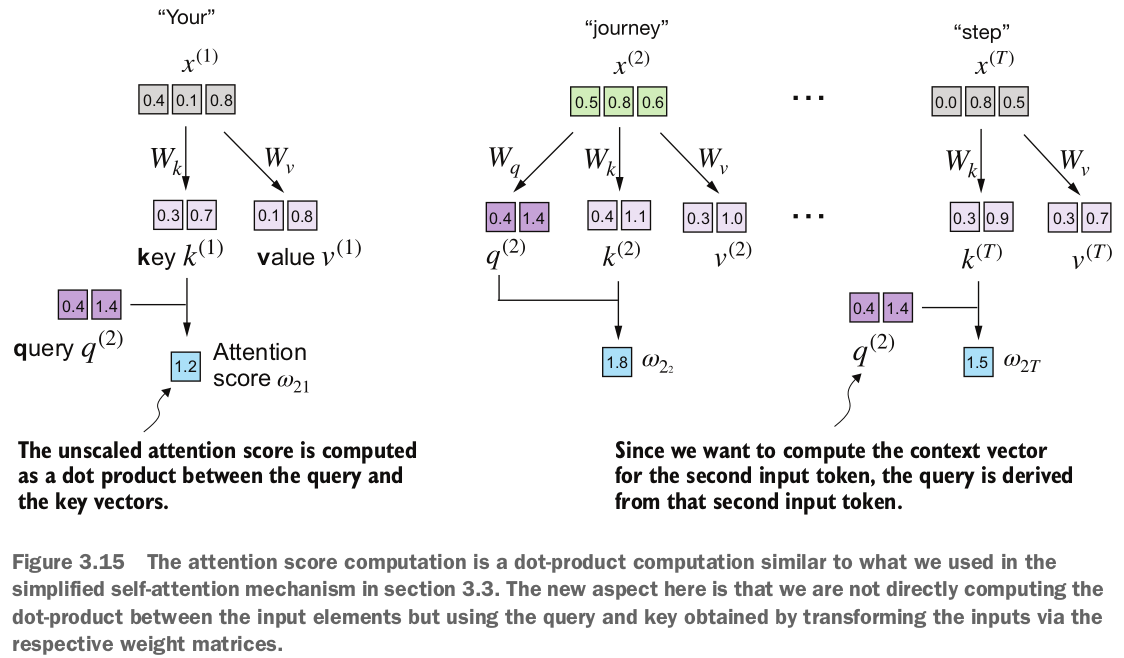

Primeiro, vamos calcular a pontuação de atenção $\omega_{22}$:

In [ ]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


Novamente, podemos generalizar esse cálculo para todas as pontuações de atenção por meio da multiplicação de matrizes:

In [ ]:
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


Como podemos ver, em uma verificação rápida, o segundo elemento na saída corresponde ao `attn_score_22` que calculamos anteriormente.

Agora, queremos passar das pontuações de atenção para os pesos de atenção, conforme ilustrado na Figura 3.16. Calculamos os pesos de atenção escalonando as pontuações de atenção e usando a função softmax. No entanto, agora escalonamos as pontuações de atenção dividindo-as pela raiz quadrada da dimensão de incorporação das chaves (extrair a raiz quadrada é matematicamente o mesmo que exponenciar por 0.5):

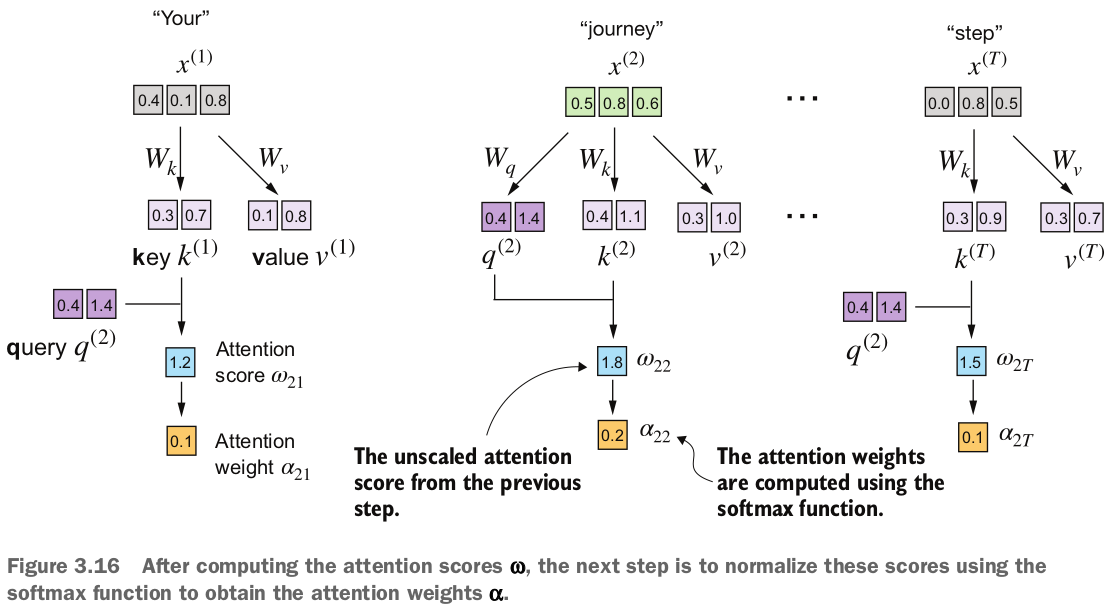

In [ ]:
d_k = keys.shape[-1] # Obtém a dimensão dos vetores de chave (key).
                     # 'keys.shape' retorna uma tupla com as dimensões do tensor 'keys'.
                     # '[-1]' acessa a última dimensão da tupla de forma, que neste caso é a dimensão dos embeddings de chave (d_out, que definimos como 2).
                     # d_k armazenará essa dimensão (2). É usado para escalar as pontuações de atenção.

attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
# Calcula os pesos de atenção normalizados usando a função softmax do PyTorch.
# 'attn_scores_2': O tensor de pontuações de atenção não normalizadas para o segundo token de entrada (calculado anteriormente).
# 'd_k**0.5': Calcula a raiz quadrada da dimensão das chaves (d_k). Isso é usado para escalar as pontuações de atenção.
#            A divisão por esta raiz quadrada é a característica definidora da "atenção por produto escalar escalonado".
# 'attn_scores_2 / d_k**0.5': Escala as pontuações de atenção não normalizadas dividindo-as pela raiz quadrada de d_k.
#                           Isso ajuda a evitar gradientes pequenos durante o treinamento quando as dimensões do embedding são grandes.
# 'torch.softmax(..., dim=-1)': Aplica a função softmax aos scores escalonados.
#                               'dim=-1' especifica que a normalização softmax deve ser aplicada ao longo da última dimensão do tensor.
#                               Para um vetor unidimensional como 'attn_scores_2', isso significa que a softmax é aplicada a todos os elementos, garantindo que a soma dos pesos seja 1.
#                               O resultado é um tensor chamado 'attn_weights_2' contendo os pesos de atenção normalizados para o segundo token de entrada em relação a todos os outros tokens.

print(attn_weights_2) # Imprime o tensor 'attn_weights_2'.
                      # Este vetor contém os pesos de atenção normalizados para o segundo token ("journey").
                      # Cada valor indica a importância relativa de um token de entrada específico para o token "journey" no contexto da autoatenção.
                      # A soma de todos os elementos neste tensor será aproximadamente 1.

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


---

$\large \textbf{A Logica por Tras da Atenção ao Produto de Ponto Escalonado}$

O motivo da normalização pelo tamanho da dimensão de incorporação é melhorar o
desempenho do treinamento, evitando pequenos gradientes. Por exemplo, ao aumentar a dimensão de incorporação, que normalmente é maior que 1.000 para LLMs do tipo GPT, grandes produtos escalares podem resultar em gradientes muito pequenos durante a retropropagação devido à
função softmax aplicada a eles. À medida que os produtos escalares aumentam, a função softmax se comporta mais como uma função degrau, resultando em gradientes próximos de zero. Esses pequenos gradientes podem desacelerar drasticamente o aprendizado ou causar a estagnação do treinamento.

O escalonamento pela raiz quadrada da dimensão de incorporação é a razão pela qual esse mecanismo de autoatenção também é chamado de atenção por produto escalar.

---

Agora, a etapa final é calcular os vetores de contexto, conforme ilustrado na figura 3.17.

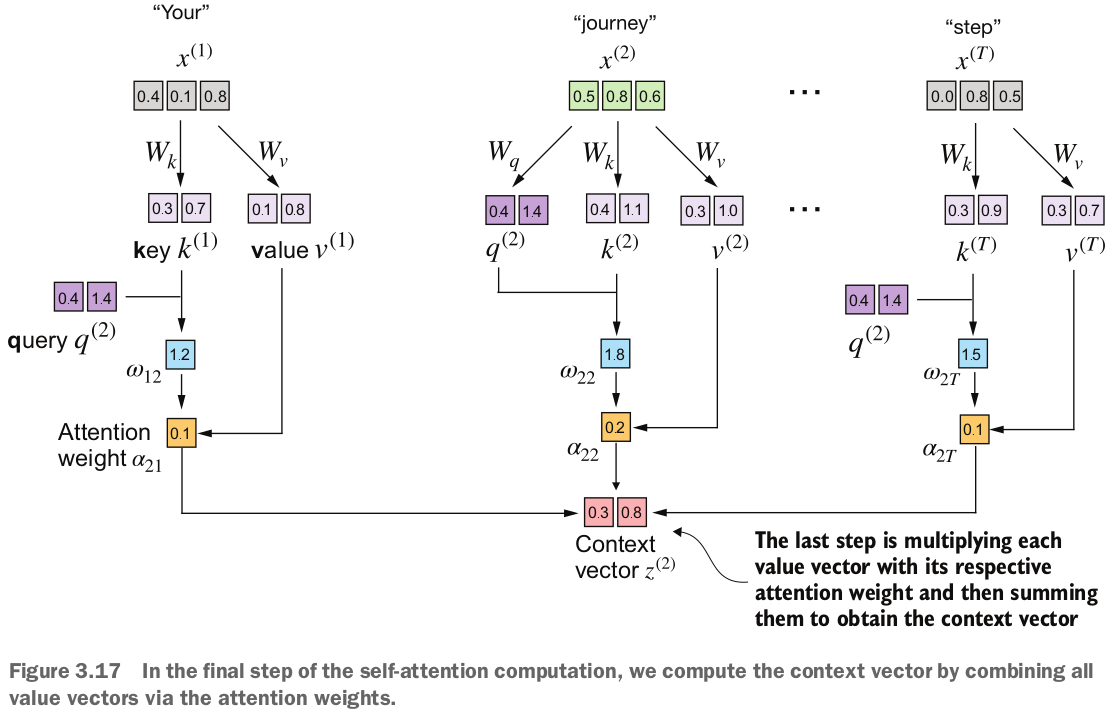

Semelhante a quando calculamos o vetor de contexto como uma soma ponderada sobre os vetores de entrada (ver seção 3.3), agora calculamos o vetor de contexto como uma soma ponderada sobre os vetores de valor. Aqui, os pesos de atenção servem como um fator de ponderação que pondera a importância respectiva de cada vetor de valor. Assim como antes, podemos usar a multiplicação de matrizes para obter a saída em uma única etapa:

In [ ]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


Até agora, calculamos apenas um único vetor de contexto, $z^{(2)}$. Em seguida, generalizaremos o código para calcular todos os vetores de contexto na sequência de entrada, de $z^{(1)}$ a $z^{(T)}$.

---

$\Large \textbf{Por que Consulta (Query), Chave (Key) e Valor (Value)}?$

Os termos “**chave (key)**”, “**consulta (query)**” e “**valor (value)**”, no contexto de mecanismos de atenção, são tomados emprestados do domínio da recuperação de informações e de bancos de dados, onde conceitos semelhantes são usados para armazenar, pesquisar e recuperar informações.

Uma ***consulta*** é análoga a uma consulta de pesquisa em um banco de dados. Ela representa o item atual (por exemplo, uma palavra ou token em uma frase) no qual o modelo se concentra ou tenta compreender. A consulta é usada para sondar as outras partes da sequência de entrada para determinar quanta atenção deve ser dada a elas.

A ***chave*** é como uma chave de banco de dados usada para indexação e pesquisa. No mecanismo de atenção, cada item na sequência de entrada (por exemplo, cada palavra em uma frase) possui uma chave associada. Essas chaves são usadas para corresponder à consulta.

O ***valor***, neste contexto, é semelhante ao valor em um par chave-valor em um banco de dados. Ele representa o conteúdo ou a representação real dos itens de entrada. Depois que o modelo determina quais chaves (e, portanto, quais partes da entrada) são mais relevantes para a consulta (o item de foco atual), ele recupera os valores correspondentes.

$\large \textbf{A Base Teorica: Attention Is All You Need}$

A arquitetura do Transformer e, por consequência, o uso de três matrizes de peso para Query, Key e Value, foi formalmente introduzida no artigo seminal *Attention Is All You Need* (Vaswani et al., 2017). Este artigo revolucionou a área de Processamento de Linguagem Natural (PLN), abandonando as redes neurais recorrentes (RNNs) em favor de um modelo inteiramente baseado em atenção.

O artigo descreve a atenção como uma função que mapeia uma consulta (*query*) e um conjunto de pares chave-valor (*key-value*) para uma saída. A saída é uma soma ponderada dos valores, onde o peso atribuído a cada valor é calculado por uma função de compatibilidade da consulta com a chave correspondente.

Essa definição matemática foi a formalização do conceito que hoje conhecemos. Os autores se basearam na intuição de que, para "se concentrar" em informações relevantes (como faria um cérebro humano), um modelo precisa de um mecanismo para:

- Saber o que está procurando (a *query*).
- Verificar o que cada item tem a oferecer (a *key*).
- Obter a informação em si (o *value*).

$\large \textbf{Por que exatamente tres matrizes?}$

Não é que não possam existir outras arquiteturas, mas a separação em três matrizes resolve um problema fundamental. Se usássemos menos matrizes, o modelo perderia a flexibilidade e a capacidade de especialização que são cruciais para a atenção.

Se usássemos apenas uma matriz (por exemplo, a mesma matriz para $Q$, $K$ e $V$), o modelo não conseguiria distinguir entre "o que estou procurando" (*Query*) e "o que eu tenho a oferecer" (*Key*). A sua pergunta seria a mesma que a sua resposta, o que limitaria drasticamente a capacidade de o modelo aprender relações complexas.

A separação em três matrizes distintas permite que o modelo aprenda três representações únicas para o mesmo token de entrada. Cada matriz ($W_q$, $W_k$, $W_v$) projeta o token em um espaço diferente, otimizado para sua respectiva função:

- $W_q$: cria uma representação que é boa para perguntar e buscar.
- $W_k$: cria uma representação que é boa para responder e ser comparada.
- $W_v$: cria uma representação que é boa para conter o conteúdo real a ser repassado.

Essa separação é a chave para a eficiência e o poder do mecanismo de atenção. Ela permite que a consulta de um token encontre as chaves relevantes dos outros tokens e, em seguida, use os valores correspondentes para construir um vetor de contexto rico e ponderado. É a analogia do banco de dados levada ao seu limite lógico para criar um sistema de busca dentro da própria arquitetura.


---

### **4.2 - Implementando uma Classe Python Compacta de Autoatenção**

Neste ponto, já passamos por várias etapas para calcular os resultados da autoatenção (self-attention). Fizemos isso principalmente para fins ilustrativos, para que pudéssemos passar por uma etapa de cada vez. Na prática, com a implementação do LLM no próximo capítulo em mente, é útil organizar este código em uma classe Python, como mostrado na listagem a seguir.

In [ ]:
import torch.nn as nn # Importa o módulo 'nn' do PyTorch, que contém classes e funções
                      # para construir e treinar redes neurais.

class SelfAttention_v1(nn.Module): # Define uma nova classe chamada 'SelfAttention_v1' que herda de 'nn.Module'.
                                   # Herdar de 'nn.Module' é padrão no PyTorch para criar camadas ou modelos reutilizáveis.
                                   # Isso fornece funcionalidades como rastreamento de parâmetros, movimentação para GPU, etc.

    def __init__(self, d_in, d_out): # Define o método construtor para a classe.
                                     # É chamado ao criar uma nova instância de SelfAttention_v1.
                                     # self: Refere-se à instância atual da classe.
                                     # d_in: A dimensão de entrada dos embeddings (o tamanho de cada vetor de token de entrada).
                                     # d_out: A dimensão de saída desejada para os vetores de consulta, chave e valor
                                     #        após a projeção pelas matrizes de peso.

        super().__init__() # Chama o construtor da classe pai (nn.Module).
                           # É importante para garantir que a funcionalidade básica de nn.Module seja inicializada corretamente.

        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        # Cria a matriz de pesos para a "query" (consulta).
        # self.W_query: Atribui a matriz de pesos como um atributo da instância.
        # nn.Parameter(...): Envolve um tensor para que ele seja considerado um parâmetro treinável do modelo.
        #                    Os valores deste tensor serão otimizados durante o treinamento (se requires_grad=True, que é o padrão para nn.Parameter).
        # torch.rand(d_in, d_out): Cria um tensor (matriz) com dimensões d_in (linhas) por d_out (colunas)
        #                          preenchido com números aleatórios uniformemente distribuídos entre 0 e 1.
        #                          Esta matriz será usada para projetar o vetor de entrada (d_in) em um vetor de query (d_out).

        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        # Cria a matriz de pesos para a "key" (chave).
        # Similar a W_query, mas esta matriz é usada para projetar os vetores de entrada em vetores de chave.
        # Tem as mesmas dimensões (d_in, d_out) que W_query e é inicializada aleatoriamente.
        # Também é um parâmetro treinável.

        self.W_value = nn.Parameter(torch.rand(d_in, d_out))
        # Cria a matriz de pesos para o "value" (valor).
        # Similar a W_query e W_key, mas esta matriz é usada para projetar os vetores de entrada em vetores de valor.
        # Tem as mesmas dimensões (d_in, d_out) que W_query e W_key e é inicializada aleatoriamente.
        # Também é um parâmetro treinável.

    def forward(self, x): # Define o método 'forward', que especifica como os dados fluem através da camada/módulo.
                          # Este método é executado quando a instância da classe é chamada como uma função (ex: sa_v1(inputs)).
                          # self: Refere-se à instância atual da classe.
                          # x: O tensor de entrada para a camada de atenção (neste caso, os embeddings de entrada).
                          #    Formato esperado: [número de tokens, dimensão de entrada (d_in)].

        keys = x @ self.W_key # Calcula a matriz de chaves (keys) para todos os tokens de entrada.
                              # 'x': O tensor de entrada (embeddings).
                              # '@': Operador de multiplicação de matrizes.
                              # 'self.W_key': A matriz de pesos treinável para as chaves.
                              # O resultado é uma matriz onde cada linha é o vetor de chave projetado para o token de entrada correspondente.
                              # Formato da saída: [número de tokens, d_out].

        queries = x @ self.W_query # Calcula a matriz de consultas (queries) para todos os tokens de entrada.
                                   # Similar ao cálculo das chaves, mas usando a matriz de pesos W_query.
                                   # O resultado é uma matriz onde cada linha é o vetor de consulta projetado para o token de entrada correspondente.
                                   # Formato da saída: [número de tokens, d_out].

        values = x @ self.W_value # Calcula a matriz de valores (values) para todos os tokens de entrada.
                                  # Similar ao cálculo das chaves e consultas, mas usando a matriz de pesos W_value.
                                  # O resultado é uma matriz onde cada linha é o vetor de valor projetado para o token de entrada correspondente.
                                  # Estes vetores de valor contêm a "informação" que será combinada.
                                  # Formato da saída: [número de tokens, d_out].

        attn_scores = queries @ keys.T # Calcula a matriz de pontuações de atenção (attention scores).
                                       # 'queries': A matriz de consultas.
                                       # 'keys.T': A transposta da matriz de chaves.
                                       # '@': Operador de multiplicação de matrizes.
                                       # A multiplicação de uma matriz [N, d_out] por uma matriz [d_out, N] (keys.T) resulta em uma matriz [N, N].
                                       # Onde N é o número de tokens.
                                       # Cada elemento [i, j] desta matriz é o produto escalar do i-ésimo vetor de consulta pelo j-ésimo vetor de chave.
                                       # Isso mede a similaridade entre o i-ésimo token (como consulta) e o j-ésimo token (como chave).
                                       # 'omega' no comentário refere-se à notação matemática comum para as pontuações de atenção não normalizadas.

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        # Calcula a matriz de pesos de atenção (attention weights) normalizados.
        # 'attn_scores': A matriz de pontuações de atenção não normalizadas.
        # 'keys.shape[-1]': Obtém a dimensão dos vetores de chave (d_out).
        # 'keys.shape[-1]**0.5': Calcula a raiz quadrada da dimensão das chaves.
        # 'attn_scores / keys.shape[-1]**0.5': Escala as pontuações de atenção dividindo-as pela raiz quadrada de d_k (escalonamento por produto escalar).
        # torch.softmax(..., dim=-1): Aplica a função softmax aos scores escalonados ao longo da última dimensão (colunas).
        #                             Isso normaliza cada linha da matriz de scores para que a soma dos pesos em cada linha seja 1.
        #                             O resultado é uma matriz [N, N] onde cada elemento [i, j] indica a importância relativa do j-ésimo token para o i-ésimo token.

        context_vec = attn_weights @ values # Calcula a matriz de vetores de contexto (context vectors).
                                            # 'attn_weights': A matriz de pesos de atenção normalizados (formato [N, N]).
                                            # 'values': A matriz de valores (formato [N, d_out]).
                                            # '@': Operador de multiplicação de matrizes.
                                            # A multiplicação de uma matriz [N, N] por uma matriz [N, d_out] resulta em uma matriz [N, d_out].
                                            # Cada linha desta matriz resultante é o vetor de contexto para o token de entrada correspondente.
                                            # Cada vetor de contexto é uma soma ponderada dos vetores de valor, onde os pesos são dados pela matriz attn_weights.
                                            # Isso combina as informações de todos os tokens (contidas nos valores) ponderadas pela sua relevância (definida pelos pesos de atenção) para criar uma representação contextualizada de cada token.

        return context_vec # Retorna a matriz de vetores de contexto.
                           # Esta é a saída da camada de autoatenção. Cada linha é o vetor de contexto para um token de entrada.

Neste código PyTorch, `SelfAttention_v1` é uma classe derivada de `nn.Module`, que é um bloco de construção fundamental dos modelos PyTorch que fornece as funcionalidades necessárias para a criação e o gerenciamento da camada do modelo.

O método `__init__` inicializa matrizes de peso treináveis (`W_query`, `W_key` e `W_value`) para consultas, chaves e valores, cada uma transformando a dimensão de entrada `d_in` em uma dimensão de saída `d_out`.

Durante a passagem de avanço, usando o método de avanço, calculamos as pontuações de atenção (`attn_scores`) multiplicando consultas e chaves, normalizando essas pontuações usando o softmax. Por fim, criamos um vetor de contexto ponderando os valores com essas pontuações de atenção normalizadas.

Podemos usar esta classe da seguinte forma:

In [ ]:
torch.manual_seed(123) # Define a semente para o gerador de números aleatórios do PyTorch.
                       # Isso garante que a inicialização dos pesos dentro da instância de SelfAttention_v1
                       # seja a mesma toda vez que o código for executado com esta semente.
                       # É útil para reprodutibilidade, garantindo que os resultados sejam consistentes
                       # para depuração e comparação.

sa_v1 = SelfAttention_v1(d_in, d_out) # Cria uma instância da classe SelfAttention_v1.
                                      # SelfAttention_v1: A classe que definimos anteriormente para a autoatenção.
                                      # (d_in, d_out): Passa os argumentos d_in (dimensão de entrada dos embeddings)
                                      #              e d_out (dimensão de saída desejada para Q, K, V) para o construtor (__init__) da classe.
                                      #              O construtor inicializará as matrizes de pesos W_query, W_key e W_value
                                      #              com base nessas dimensões.
                                      # sa_v1: A variável que armazena a instância criada do módulo de autoatenção.

print(sa_v1(inputs)) # Chama o método forward da instância sa_v1, passando o tensor 'inputs' como entrada.
                     # sa_v1(...): Quando uma instância de um módulo nn.Module é chamada como uma função,
                     #             o método forward dessa instância é executado.
                     # inputs: O tensor de entrada contendo os embeddings da sequência de texto.
                     #         Este tensor será processado pelo método forward da camada de autoatenção.
                     # O método forward calculará e retornará os vetores de contexto para cada token de entrada.
                     # print(...): Imprime o tensor resultante (os vetores de contexto) no console.
                     # A saída será uma matriz onde cada linha representa o vetor de contexto para um token de entrada,
                     # refletindo a informação de toda a sequência ponderada pela autoatenção.

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


Como as entradas contêm seis vetores de incorporação, isso resulta em uma matriz que armazena os seis vetores de contexto.

Para uma verificação rápida, observe que a segunda linha $(\textbf{[0,3061, 0,8210]})$ corresponde ao conteúdo de `context_vec_2` na seção anterior. A Figura 3.18 resume o mecanismo de autoatenção que acabamos de implementar.

A autoatenção envolve as matrizes de pesos treináveis $W_q$, $W_k$ e $W_v$. Essas matrizes transformam os dados de entrada em consultas, chaves e valores, respectivamente, que são componentes cruciais do mecanismo de atenção. À medida que o modelo é exposto a mais dados durante o treinamento, ele ajusta esses pesos treináveis, como veremos nos próximos capítulos.

Podemos aprimorar ainda mais a implementação de `SelfAttention_v1` utilizando as camadas `nn.Linear` do PyTorch, que realizam a multiplicação de matrizes de forma eficaz quando as unidades de viés estão desabilitadas. Além disso, uma vantagem significativa de usar `nn.Linear` em vez de implementar manualmente `nn.Parameter(torch.rand(...))` é que `nn.Linear` possui um esquema de inicialização de pesos otimizado, contribuindo para um treinamento de modelo mais estável e eficaz.

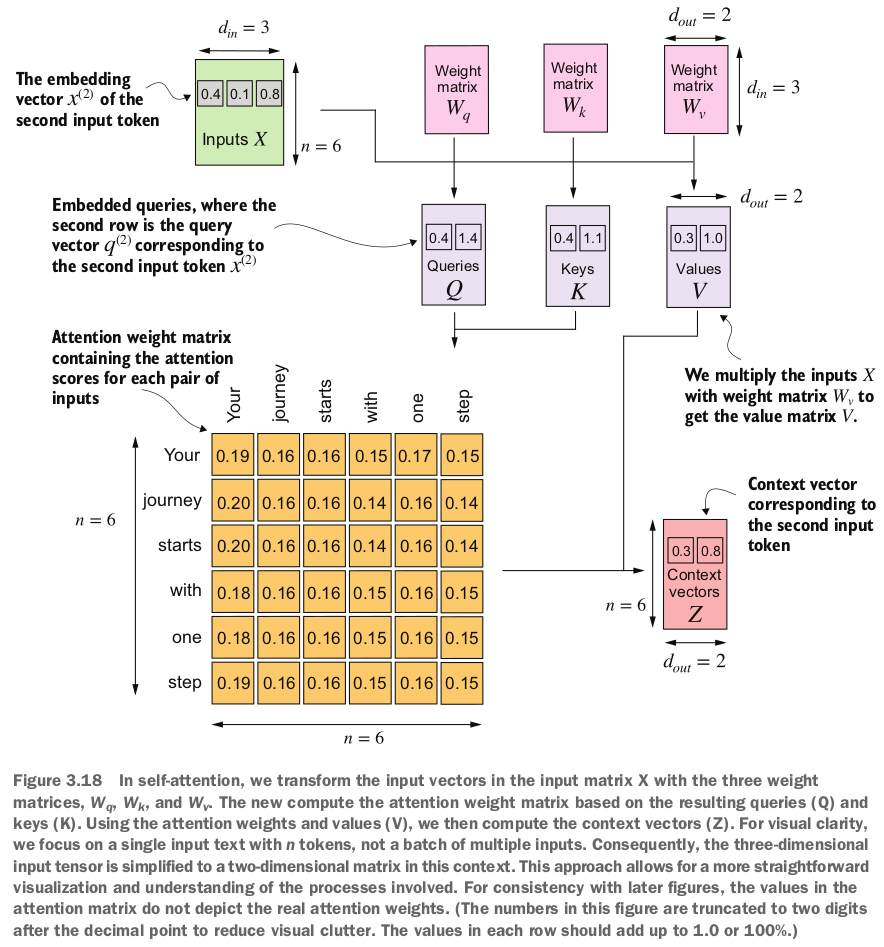

In [ ]:
class SelfAttention_v2(nn.Module): # Define uma nova classe chamada 'SelfAttention_v2' que herda de 'nn.Module'.
                                   # Assim como SelfAttention_v1, herdar de nn.Module é padrão no PyTorch para criar camadas
                                   # e aproveitar funcionalidades como rastreamento de parâmetros e movimentação para dispositivos (CPU/GPU).
    def __init__(self, d_in, d_out, qkv_bias=False): # Define o método construtor para a classe.
                                                     # É chamado ao criar uma nova instância de SelfAttention_v2.
                                                     # self: Refere-se à instância atual da classe.
                                                     # d_in: A dimensão de entrada dos embeddings (o tamanho de cada vetor de token de entrada).
                                                     # d_out: A dimensão de saída desejada para os vetores de consulta, chave e valor
                                                     #        após a projeção pelas camadas lineares.
                                                     # qkv_bias: Um parâmetro booleano opcional para incluir ou não um termo de viés (bias)
                                                     #           nas camadas lineares de query, key e value. O padrão é False,
                                                     #           o que significa que as camadas atuam como multiplicação de matrizes puras
                                                     #           (sem adição de viés).

        super().__init__() # Chama o construtor da classe pai (nn.Module).
                           # Essencial para inicializar corretamente o módulo pai e suas funcionalidades.

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Cria a camada linear (que inclui a matriz de pesos e opcionalmente o viés) para a "query" (consulta).
        # self.W_query: Atribui a camada linear como um atributo da instância.
        # nn.Linear(d_in, d_out, bias=qkv_bias): Cria uma camada linear que mapeia entradas de dimensão d_in
        #                                     para saídas de dimensão d_out.
        #                                     Esta camada contém internamente uma matriz de pesos treinável (com formato [d_out, d_in], transposta
        #                                     em relação ao que usamos manualmente em v1, por convenção do nn.Linear)
        #                                     e, se bias=True, um vetor de viés treinável.
        #                                     Esta camada será usada para projetar o vetor de entrada (d_in) em um vetor de query (d_out).

        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Cria a camada linear para a "key" (chave).
        # Similar a W_query, mas usada para projetar os vetores de entrada em vetores de chave.
        # Tem a mesma configuração de dimensão e viés que W_query.

        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Cria a camada linear para o "value" (valor).
        # Similar a W_query e W_key, mas usada para projetar os vetores de entrada em vetores de valor.
        # Tem a mesma configuração de dimensão e viés que W_query.

    def forward(self, x): # Define o método 'forward', que especifica como os dados (tensor x) fluem através da camada de atenção.
                          # self: Refere-se à instância atual da classe.
                          # x: O tensor de entrada para a camada de atenção (neste caso, os embeddings de entrada de todos os tokens).
                          #    Formato esperado: [número de tokens, dimensão de entrada (d_in)].

        keys = self.W_key(x) # Aplica a camada linear W_key à entrada x para obter a matriz de chaves (keys).
                             # A operação nn.Linear(d_in, d_out) em x (formato [N, d_in]) realiza internamente
                             # a multiplicação de matrizes x @ W_key.T + bias.
                             # Como bias=False por padrão, é equivalente a x @ W_key.T.
                             # No entanto, W_key em nn.Linear é armazenado como [d_out, d_in], então a operação é x @ W_key.T.
                             # O resultado 'keys' é uma matriz onde cada linha é o vetor de chave projetado para o token correspondente.
                             # Formato da saída: [número de tokens, d_out].

        queries = self.W_query(x) # Aplica a camada linear W_query à entrada x para obter a matriz de consultas (queries).
                                  # Similar ao cálculo das chaves, usando a camada W_query.
                                  # Formato da saída: [número de tokens, d_out].

        values = self.W_value(x) # Aplica a camada linear W_value à entrada x para obter a matriz de valores (values).
                                 # Similar ao cálculo das chaves e consultas, usando a camada W_value.
                                 # Estes vetores de valor contêm a "informação" que será combinada.
                                 # Formato da saída: [número de tokens, d_out].

        attn_scores = queries @ keys.T # Calcula a matriz de pontuações de atenção (attention scores).
                                       # 'queries': A matriz de consultas (formato [N, d_out]).
                                       # 'keys.T': A transposta da matriz de chaves (formato [d_out, N]).
                                       # '@': Operador de multiplicação de matrizes.
                                       # A multiplicação de uma matriz [N, d_out] por uma matriz [d_out, N] resulta em uma matriz [N, N].
                                       # Onde N é o número de tokens.
                                       # Cada elemento [i, j] desta matriz é o produto escalar do i-ésimo vetor de consulta pelo j-ésimo vetor de chave.
                                       # Isso mede a similaridade entre o i-ésimo token (como consulta) e o j-ésimo token (como chave).

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        # Calcula a matriz de pesos de atenção (attention weights) normalizados.
        # 'attn_scores': A matriz de pontuações de atenção não normalizadas (formato [N, N]).
        # 'keys.shape[-1]': Obtém a dimensão dos vetores de chave (d_out).
        # 'keys.shape[-1]**0.5': Calcula a raiz quadrada da dimensão das chaves.
        # 'attn_scores / keys.shape[-1]**0.5': Escala as pontuações de atenção dividindo-as pela raiz quadrada de d_k (escalonamento por produto escalar).
        #                                   Isso ajuda a evitar gradientes pequenos durante o treinamento quando as dimensões do embedding são grandes.
        # torch.softmax(..., dim=-1): Aplica a função softmax aos scores escalonados ao longo da última dimensão (colunas).
        #                             Isso normaliza cada linha da matriz de scores para que a soma dos pesos em cada linha seja 1.
        #                             O resultado é uma matriz [N, N] onde cada elemento [i, j] indica a importância relativa do j-ésimo token para o i-ésimo token.

        context_vec = attn_weights @ values # Calcula a matriz de vetores de contexto (context vectors).
                                            # 'attn_weights': A matriz de pesos de atenção normalizados (formato [N, N]).
                                            # 'values': A matriz de valores (formato [N, d_out]).
                                            # '@': Operador de multiplicação de matrizes.
                                            # A multiplicação de uma matriz [N, N] por uma matriz [N, d_out] resulta em uma matriz [N, d_out].
                                            # Cada linha desta matriz resultante é o vetor de contexto para o token de entrada correspondente.
                                            # Cada vetor de contexto é uma soma ponderada dos vetores de valor, onde os pesos são dados pela matriz attn_weights.
                                            # Isso combina as informações de todos os tokens (contidas nos valores) ponderadas pela sua relevância (definida pelos pesos de atenção) para criar uma representação contextualizada de cada token.

        return context_vec # Retorna a matriz de vetores de contexto.
                           # Esta é a saída da camada de autoatenção. Cada linha é o vetor de contexto para um token de entrada.

Você pode usar o `SelfAttention_v2` similar ao `SelfAttention_v1`:

In [ ]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


Observe que `SelfAttention_v1` e `SelfAttention_v2` fornecem saídas diferentes porque usam pesos iniciais diferentes para as matrizes de peso, já que `nn.Linear` usa um esquema de inicialização de peso mais sofisticado.

---

$\large \textbf{Exercício 3.1 Comparando $\verb|SelfAttention_v1|$ e $\verb|SelfAttention_v2|$}$

Observe que `nn.Linear` em `SelfAttention_v2` usa um esquema de inicialização de pesos diferente de `nn.Parameter(torch.rand(d_in, d_out))` usado em `SelfAttention_v1`, o que faz com que ambos os mecanismos produzam resultados diferentes. Para verificar se ambas as implementações, `SelfAttention_v1` e `SelfAttention_v2`, são semelhantes, podemos transferir as matrizes de pesos de um objeto `SelfAttention_v2` para um `SelfAttention_v1`, de forma que ambos os objetos produzam os mesmos resultados.

Sua tarefa é atribuir corretamente os pesos de uma instância de `SelfAttention_v2` a uma instância de `SelfAttention_v1`. Para isso, você precisa entender a relação entre os pesos em ambas as versões. (Dica: `nn.Linear` armazena a matriz de pesos em uma forma transposta.) Após a atribuição, você deve observar que ambas as instâncias produzem as mesmas saídas.

---

Em seguida, faremos aprimoramentos no mecanismo de autoatenção, com foco específico na incorporação de elementos causais e multicabeças. O aspecto causal envolve a modificação do mecanismo de atenção para impedir que o modelo acesse informações futuras na sequência, o que é crucial para tarefas como modelagem de linguagem, em que a previsão de cada palavra deve depender apenas de palavras anteriores.

O componente multicabeças envolve a divisão do mecanismo de atenção em múltiplas "cabeças". Cada cabeça aprende diferentes aspectos dos dados, permitindo que o modelo atenda simultaneamente a informações de diferentes subespaços de representação em diferentes posições. Isso melhora o desempenho do modelo em tarefas complexas.

## **5 - Escondendo Palavras Futuras com Atenção Causal (Causal Attention)**

Para muitas tarefas de LLM, você desejará que o mecanismo de autoatenção considere apenas os tokens que aparecem antes da posição atual ao prever o próximo token em uma sequência. A atenção causal, também conhecida como ***atenção mascarada (masked attention)***, é uma forma especializada de autoatenção. Ela restringe um modelo a considerar apenas as entradas anteriores e atuais em uma sequência ao processar qualquer token ao calcular as pontuações de atenção. Isso contrasta com o mecanismo de autoatenção padrão, que permite acesso a toda a sequência de entrada de uma só vez.

Agora, modificaremos o mecanismo de autoatenção padrão para criar um mecanismo de ***atenção causal (causal attention)***, essencial para o desenvolvimento de um LLM nos capítulos subsequentes. Para conseguir isso em LLMs do tipo GPT, para cada token processado, mascaramos os tokens futuros, que vêm depois do token atual no texto de entrada, conforme ilustrado na figura 3.19. Mascaramos os pesos de atenção acima da diagonal e normalizamos os pesos de atenção não mascarados de forma que a soma dos pesos de atenção seja igual a 1 em cada linha. Mais tarde, implementaremos esse procedimento de mascaramento e normalização no código.

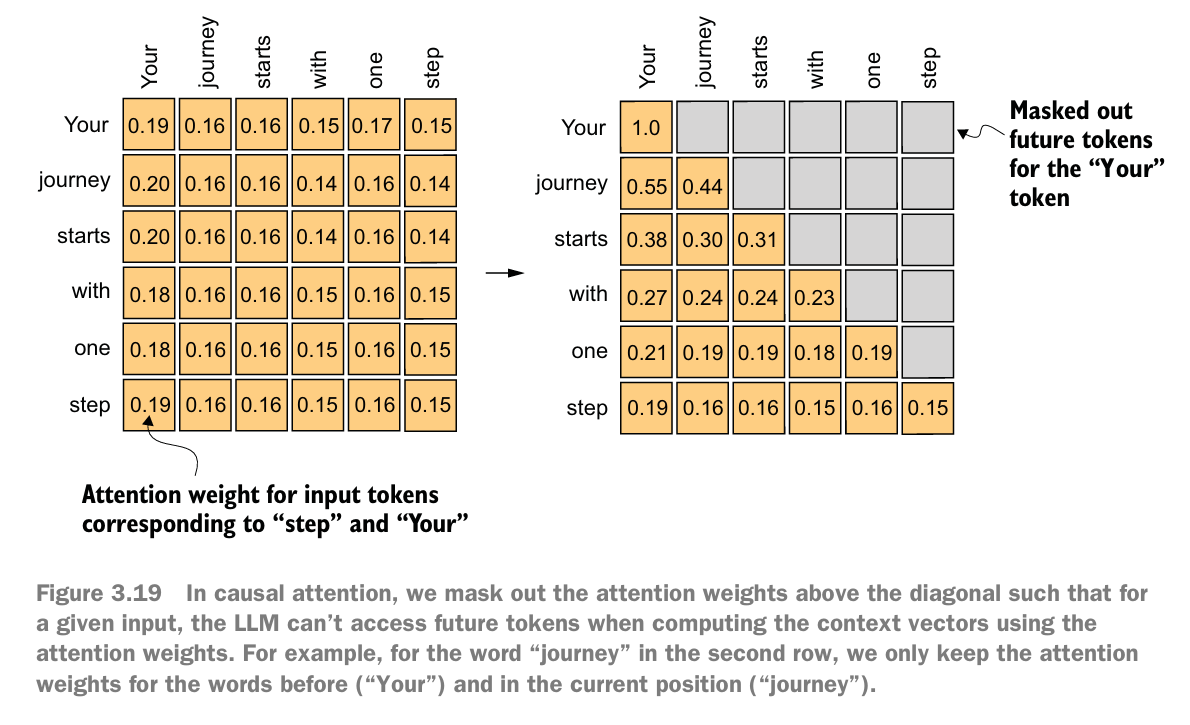

### **5.1 - Ocultando Palavras Futuras com Atenção Causal**

Nosso próximo passo é implementar a máscara de atenção causal em código. Para implementar as etapas de aplicação de uma máscara de atenção causal e obter os pesos de atenção mascarados, conforme resumido na Figura 3.20, vamos trabalhar com as pontuações e pesos de atenção da seção anterior para codificar o mecanismo de atenção causal.

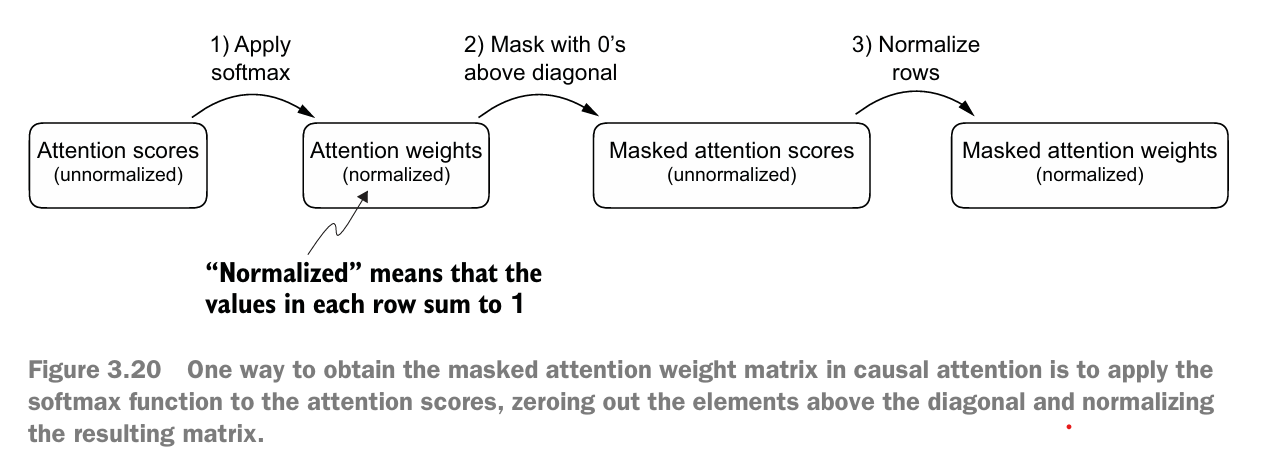

Na primeira etapa, calculamos os pesos de atenção usando a função softmax, como fizemos anteriormente:

In [ ]:
# Aplica a camada linear W_query da instância sa_v2 ao tensor de entrada 'inputs'.
# 'sa_v2.W_query': Esta é a camada linear criada no __init__ da classe SelfAttention_v2,
#                  responsável por transformar os embeddings de entrada em vetores de consulta.
#                  Internamente, ela contém a matriz de pesos treinável W_query.
# 'inputs': O tensor de entrada que contém os embeddings de todos os tokens da sequência.
#           Sua forma é [número de tokens, dimensão de entrada (d_in)].
# Ao chamar sa_v2.W_query(inputs), o método forward da camada nn.Linear é executado,
# realizando a multiplicação de matrizes entre 'inputs' e a transposta da matriz de pesos de W_query (mais a adição de viés se qkv_bias fosse True).
# O resultado 'queries' é uma matriz onde cada linha é o vetor de consulta projetado para o token de entrada correspondente.
# Formato da saída: [número de tokens, dimensão de saída (d_out)].
# Cada linha representa o que o modelo está "procurando" nos outros tokens.
queries = sa_v2.W_query(inputs)

# Aplica a camada linear W_key da instância sa_v2 ao tensor de entrada 'inputs'.
# 'sa_v2.W_key': Esta é a camada linear para as chaves.
# 'inputs': O mesmo tensor de entrada.
# Similar ao cálculo das consultas, esta operação projeta os embeddings de entrada nos vetores de chave.
# O resultado 'keys' é uma matriz onde cada linha é o vetor de chave projetado para o token de entrada correspondente.
# Formato da saída: [número de tokens, dimensão de saída (d_out)].
# Cada linha representa o que este token "oferece" para ser encontrado pelas consultas de outros tokens.
keys = sa_v2.W_key(inputs)

# Calcula a matriz de pontuações de atenção (attention scores).
# 'queries': A matriz de consultas (formato [número de tokens, d_out]). Cada linha é uma consulta de um token.
# 'keys.T': A transposta da matriz de chaves (formato [d_out, número de tokens]). Cada coluna é uma chave de um token.
# '@': Operador de multiplicação de matrizes.
# A multiplicação de uma matriz [N, d_out] por uma matriz [d_out, N] resulta em uma matriz [N, N],
# onde N é o número de tokens na sequência (6 neste caso).
# Cada elemento [i, j] desta matriz resultante ('attn_scores') é o produto escalar do i-ésimo vetor de consulta (queries[i, :])
# pelo j-ésimo vetor de chave (keys[j, :]).
# Este produto escalar mede a similaridade ou compatibilidade entre o i-ésimo token (como consulta)
# e o j-ésimo token (como chave). Uma pontuação alta significa que o i-ésimo token deve prestar muita atenção ao j-ésimo token.
attn_scores = queries @ keys.T

# Calcula a matriz de pesos de atenção (attention weights) normalizados.
# 'attn_scores': A matriz de pontuações de atenção não normalizadas (formato [N, N]).
# 'keys.shape[-1]': Obtém a dimensão dos vetores de chave (d_out, que é 2 neste caso).
#                   O índice [-1] refere-se à última dimensão.
# 'keys.shape[-1]**0.5': Calcula a raiz quadrada da dimensão das chaves. Isso é o fator de escalonamento (sqrt(d_k)).
#                       Usar a raiz quadrada de d_k ajuda a evitar que os produtos escalares fiquem muito grandes,
#                       o que poderia resultar em gradientes muito pequenos após o softmax, dificultando o treinamento.
# 'attn_scores / keys.shape[-1]**0.5': Escala as pontuações de atenção não normalizadas dividindo-as pela raiz quadrada de d_k.
# torch.softmax(..., dim=-1): Aplica a função softmax aos scores escalonados.
#                             'dim=-1' especifica que a normalização softmax deve ser aplicada ao longo da última dimensão (colunas) da matriz 'attn_scores'.
#                             Para uma matriz [N, N], isso significa que cada linha é tratada independentemente,
#                             e os valores dentro de cada linha são normalizados para que a soma de todos os elementos em CADA LINHA seja 1.
#                             O resultado 'attn_weights' é uma matriz [N, N] onde cada elemento [i, j] indica a importância relativa
#                             (o peso de atenção) do j-ésimo token para o i-ésimo token.
#                             A linha 'i' mostra como a atenção do i-ésimo token é distribuída entre todos os tokens na sequência.
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

# Imprime a matriz de pesos de atenção calculada.
# Esta matriz mostra graficamente (em valores numéricos) o quão "atencioso" cada token
# (representado pela linha) é para todos os outros tokens na sequência (representados pelas colunas).
# Valores mais altos indicam maior foco ou importância atribuída a um token específico.
# Por exemplo, se a linha 1 tivesse um valor alto na coluna 3, significaria que o segundo token
# presta muita atenção ao quarto token ao calcular sua própria representação contextualizada.
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Podemos implementar o segundo passo usando a função `tril` do PyTorch para criar uma máscara onde os valores acima da diagonal são zero:

In [ ]:
# Obtém o comprimento da sequência de contexto.
# 'attn_scores': É a matriz de pontuações de atenção calculada anteriormente. Sua forma é [número de tokens, número de tokens].
# 'attn_scores.shape': Retorna uma tupla representando as dimensões do tensor 'attn_scores'.
# '[0]': Acessa o primeiro elemento da tupla de forma, que corresponde ao número de linhas (e colunas) na matriz,
#        ou seja, o número de tokens na sequência de entrada.
# 'context_length': Armazena esse número. É o tamanho da sequência que estamos processando.
context_length = attn_scores.shape[0]

# Cria uma máscara triangular inferior (lower triangular mask).
# 'torch.ones(context_length, context_length)': Cria um tensor preenchido com 1s com as dimensões (context_length, context_length).
#                                              Neste caso, cria uma matriz 6x6 de 1s.
# 'torch.tril(...)': Aplica a função 'tril' (lower triangular) a esta matriz de 1s.
#                    A função 'tril' define para zero todos os elementos acima da diagonal principal.
#                    O resultado é uma matriz onde os elementos na diagonal principal e abaixo são 1s,
#                    e os elementos acima da diagonal principal são 0s.
# 'mask_simple': Armazena esta matriz máscara triangular inferior.
#                Esta máscara será usada para "mascarar" ou zerar as pontuações de atenção de tokens futuros.
mask_simple = torch.tril(torch.ones(context_length, context_length))

# Imprime a máscara triangular inferior criada.
# Visualizar a máscara ajuda a entender quais elementos das pontuações de atenção serão mantidos (multiplicados por 1)
# e quais serão zerados (multiplicados por 0) na próxima etapa.
# A linha 'i' e coluna 'j' de mask_simple será 1 se j <= i (tokens passados ou o token atual)
# e 0 se j > i (tokens futuros).
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Agora, podemos multiplicar essa máscara pelos pesos de atenção para zerar os valores acima da diagonal:

In [ ]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


Como podemos ver, os elementos acima da diagonal foram zerados com sucesso.

O terceiro passo é renormalizar os pesos de atenção para que a soma seja 1 novamente em cada linha. Podemos fazer isso dividindo cada elemento em cada linha pela soma em cada linha:

In [ ]:
# Calcula a soma de cada linha na matriz 'masked_simple'.
# 'masked_simple': A matriz de pontuações de atenção mascaradas (onde os elementos acima da diagonal são zero).
# '.sum(...)': Chama o método sum no tensor 'masked_simple'.
# 'dim=-1': Especifica que a soma deve ser calculada ao longo da última dimensão do tensor (colunas).
#           Para uma matriz, isso significa que a soma é calculada horizontalmente, resultando em um vetor onde cada elemento é a soma de uma linha correspondente.
# 'keepdim=True': Este parâmetro opcional mantém a dimensão reduzida na saída.
#                 Se keepdim fosse False (padrão), a saída seria um tensor 1D. Com keepdim=True,
#                 a saída é um tensor 2D com uma única coluna (formato [número de tokens, 1]).
#                 Isso é útil para a próxima operação de divisão, pois permite que a soma de cada linha
#                 seja dividida elemento a elemento pela linha correspondente na matriz 'masked_simple'
#                 através do broadcasting.
# 'row_sums': Armazena o tensor contendo a soma de cada linha.
row_sums = masked_simple.sum(dim=-1, keepdim=True)

# Renormaliza a matriz mascarada dividindo cada elemento pela soma da sua linha correspondente.
# 'masked_simple': A matriz de pontuações de atenção mascaradas.
# '/': Operador de divisão elemento a elemento.
# 'row_sums': O tensor contendo a soma de cada linha.
#             Graças a 'keepdim=True' na linha anterior, 'row_sums' tem o formato [número de tokens, 1].
#             O PyTorch usa broadcasting: o valor da soma em cada linha de 'row_sums' é "esticado"
#             para dividir todos os elementos da linha correspondente em 'masked_simple'.
#             Isso garante que a soma dos elementos em cada linha do tensor resultante seja 1.
# 'masked_simple_norm': Armazena a matriz de pesos de atenção mascarados e renormalizados.
#                       Esta matriz agora representa a distribuição de atenção para cada token,
#                       considerando apenas os tokens anteriores e o atual, e com a soma de cada linha igual a 1.
masked_simple_norm = masked_simple / row_sums

# Imprime a matriz de pesos de atenção mascarados e renormalizados.
# Esta saída mostra os pesos de atenção finais para este método de mascaramento,
# onde os elementos acima da diagonal são zero e os elementos em cada linha somam 1.
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


O resultado é uma matriz de peso de atenção onde os pesos de atenção acima da diagonal são zerados e as linhas somam 1.

---

$\large \textbf{Vazamento de Informacoes}$

Quando aplicamos uma máscara e, em seguida, renormalizamos os pesos de atenção, pode parecer inicialmente que as informações de tokens futuros (que pretendemos mascarar) ainda podem influenciar o token atual, pois seus valores fazem parte do cálculo do softmax. No entanto, a principal conclusão é que, quando renormalizamos os pesos de atenção após o mascaramento, o que estamos essencialmente fazendo é recalcular o softmax sobre um subconjunto menor (já que as posições mascaradas não contribuem para o valor do softmax).

A elegância matemática do softmax é que, apesar de inicialmente incluir todas as posições no denominador, após o mascaramento e a renormalização, o efeito das posições mascaradas é anulado — elas não contribuem para a pontuação do softmax de forma significativa.

Em termos mais simples, após o mascaramento e a renormalização, a distribuição dos pesos de atenção é como se tivesse sido calculada inicialmente apenas entre as posições não mascaradas.
Isso garante que não haja vazamento de informações de tokens futuros (ou mascarados de outra forma), como pretendíamos.

---

Embora pudéssemos concluir nossa implementação da atenção causal neste ponto, ainda podemos aprimorá-la. Vamos pegar uma propriedade matemática da função softmax e implementar no cálculo dos pesos de atenção mascarados de forma mais eficiente e em menos etapas, como mostrado na figura 3.21.

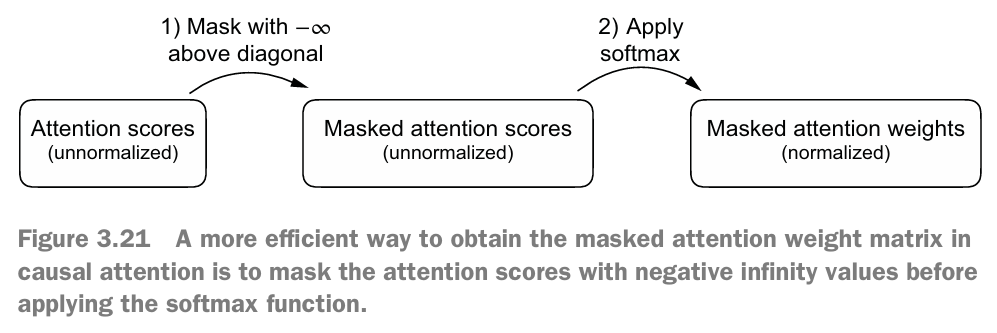

A função softmax converte suas entradas em uma distribuição de probabilidade. Quando valores negativos de infinito ($-\infty$) estão presentes em uma linha, a função softmax os trata como probabilidade zero. (Matematicamente, isso ocorre porque $e^{-\infty}$ se aproxima de 0.)

Podemos implementar esse "truque" de mascaramento mais eficiente criando uma máscara com 1s acima da diagonal e, em seguida, substituindo esses 1s por valores negativos de infinito (`-inf`):

In [ ]:
# Cria uma máscara triangular superior (upper triangular mask).
# 'torch.ones(context_length, context_length)': Cria um tensor preenchido com 1s com as dimensões (context_length, context_length).
#                                              Neste caso, cria uma matriz 6x6 de 1s.
# 'torch.triu(...)': Aplica a função 'triu' (upper triangular) a esta matriz de 1s.
#                    A função 'triu' define para zero todos os elementos abaixo da diagonal principal.
#                    'diagonal=1': Este parâmetro especifica que a diagonal a partir da qual os zeros são colocados é a primeira diagonal acima da diagonal principal.
#                                  Isso significa que os elementos na diagonal principal e abaixo serão 0s,
#                                  e os elementos acima da primeira diagonal (incluindo a primeira diagonal acima) serão 1s.
# 'mask': Armazena esta matriz máscara triangular superior.
#         Esta máscara terá 1s nas posições correspondentes aos tokens futuros (acima da diagonal principal, a partir da diagonal 1)
#         e 0s nas posições correspondentes aos tokens presentes ou passados.
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)

# Aplica a máscara à matriz de pontuações de atenção.
# 'attn_scores': A matriz de pontuações de atenção não normalizadas (formato [N, N]).
# '.masked_fill_(...)': Um método in-place (indicado pelo underscore _) que preenche elementos de um tensor com um valor específico
#                       onde uma máscara booleana correspondente é True.
#                       'mask.bool()': Converte o tensor 'mask' (que contém 0s e 1s) em um tensor booleano,
#                                      onde 0 se torna False e 1 se torna True.
#                                      As posições com True nesta máscara booleana correspondem aos elementos acima da diagonal principal (a partir da diagonal 1),
#                                      que representam as pontuações de atenção para tokens futuros.
#                       '-torch.inf': O valor com o qual os elementos mascarados serão preenchidos.
#                                     Substituir as pontuações de atenção dos tokens futuros por menos infinito (-inf)
#                                     garante que, após a aplicação da função softmax na próxima etapa,
#                                     as probabilidades (pesos de atenção) para essas posições se tornem zero (e^⁻∞ ≈ 0).
#                                     Isso efetivamente impede que o modelo "veja" ou preste atenção a tokens futuros.
# 'masked': Armazena a matriz de pontuações de atenção com os valores dos tokens futuros substituídos por -inf.
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)

# Imprime a matriz de pontuações de atenção mascaradas.
# Esta matriz mostra as pontuações de atenção onde as interações com tokens futuros foram "mascaradas"
# (substituídas por -inf) para impor a causalidade.
# Os valores -inf aparecerão nas posições acima da diagonal principal, indicando que essas conexões foram efetivamente zeradas para fins de atenção.
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


Agora, tudo o que precisamos fazer é aplicar a função softmax a esses resultados mascarados e pronto:

In [ ]:
 attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
 print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Como podemos ver com base na saída, a soma dos valores em cada linha é 1, e nenhuma normalização adicional é necessária.

Agora podemos usar os pesos de atenção modificados para calcular os vetores de contexto via `context_vec = attn_weights @ values`, como na seção 3.4. No entanto, primeiro abordaremos outro pequeno ajuste no mecanismo de atenção causal, útil para reduzir o sobreajuste ao treinar LLMs.

### **5.2 - Mascarando Pesos de Atenção Adicionais com Abandono**

***Dropout*** em aprendizado profundo é uma técnica em que unidades de camadas ocultas selecionadas aleatoriamente são ignoradas durante o treinamento, efetivamente "descartando-as". Esse método ajuda a evitar o sobreajuste, garantindo que um modelo não se torne excessivamente dependente de nenhum conjunto específico de unidades de camadas ocultas. É importante enfatizar que o dropout é usado apenas durante o treinamento e é desabilitado posteriormente.

Na arquitetura do transformador, incluindo modelos como o GPT, o dropout no mecanismo de atenção é normalmente aplicado em dois momentos específicos: após o cálculo dos pesos de atenção ou após a aplicação dos pesos de atenção aos vetores de valor. Aqui, aplicaremos a máscara de dropout após o cálculo dos pesos de atenção, conforme ilustrado na Figura 3.22, por ser a variante mais comum na prática.

No exemplo de código a seguir, usamos uma taxa de dropout de 50%, o que significa mascarar metade dos pesos de atenção. (Quando treinarmos o modelo GPT em capítulos posteriores, usaremos uma taxa de abandono menor, como 0,1 ou 0,2.) Aplicamos a implementação de abandono do PyTorch primeiro a um tensor $6 × 6$ consistindo de 1s para simplificar:

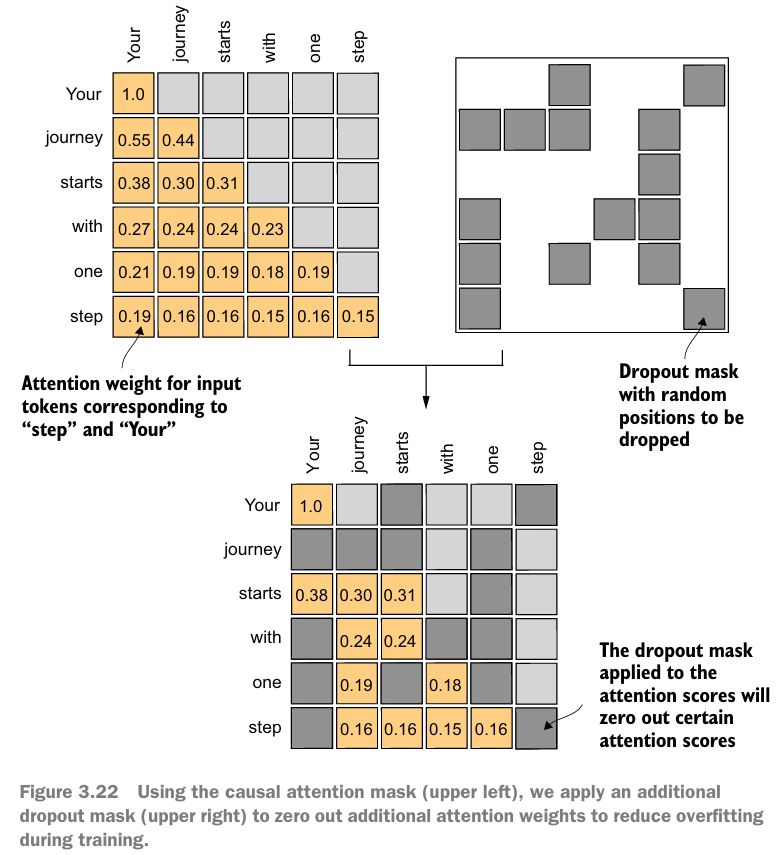

In [ ]:
# Define a semente para o gerador de números aleatórios do PyTorch.
# 'torch.manual_seed(123)': Garante que a operação de dropout (que envolve aleatoriedade)
#                          produza os mesmos resultados a cada execução com esta semente.
#                          Isso é útil para depuração e para garantir a reprodutibilidade dos experimentos.
torch.manual_seed(123)

# Cria uma instância da camada de Dropout do PyTorch.
# 'torch.nn.Dropout(0.5)': Cria um objeto Dropout.
#                         '0.5': Este é o parâmetro 'p' ou 'rate' da camada Dropout.
#                                Representa a probabilidade de um elemento (neste caso, um peso de atenção)
#                                ser zerado (descartado) durante o treinamento.
#                                Uma taxa de 0.5 significa que, em média, 50% dos elementos serão zerados.
#                                Durante a fase de treinamento, os elementos restantes são escalados por 1/(1-p)
#                                para manter a soma esperada. Durante a inferência, o dropout é desativado.
# 'dropout': Armazena a instância da camada Dropout criada.
dropout = torch.nn.Dropout(0.5)

# Cria um tensor de exemplo preenchido com uns.
# 'torch.ones(6, 6)': Cria um tensor bidimensional (uma matriz) com 6 linhas e 6 colunas.
#                     Todos os elementos deste tensor são inicializados com o valor 1.
#                     Este tensor 'example' serve como uma entrada de demonstração para mostrar o efeito do dropout.
# 'example': Armazena o tensor de exemplo.
example = torch.ones(6, 6)

# Aplica a operação de dropout ao tensor de exemplo e imprime o resultado.
# 'dropout(example)': Chama a instância da camada Dropout como uma função, passando o tensor 'example' como entrada.
#                     Quando chamada assim durante a fase de *treinamento* (o comportamento padrão quando a instância
#                     é criada e não está no modo eval()), a camada aplica a operação de dropout:
#                     1. Seleciona aleatoriamente elementos do tensor 'example' com base na probabilidade 'p' (0.5).
#                     2. Define os valores dos elementos selecionados para zero.
#                     3. Escala os valores dos elementos restantes multiplicando-os por 1 / (1 - 0.5) = 2.
#                     O resultado é um novo tensor onde alguns 1s foram substituídos por 0s e os 1s restantes foram transformados em 2s.
# 'print(...)': Imprime o tensor resultante no console.
#               A saída mostrará a matriz 6x6 com 0s em aproximadamente metade das posições e 2s nas posições restantes,
#               demonstrando como o dropout aleatoriamente descarta (zera) elementos e escala os que permanecem.
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


Ao aplicar o dropout a uma matriz de pesos de atenção com uma taxa de $50\%$, metade dos elementos da matriz são aleatoriamente zerados. Para compensar a redução nos elementos ativos, os valores dos elementos restantes na matriz são aumentados por um fator de $\frac{1}{0.5} = 2$. Esse escalonamento é crucial para manter o equilíbrio geral dos pesos de atenção, garantindo que a influência média do mecanismo de atenção permaneça consistente durante as fases de treinamento e inferência.

Agora, vamos aplicar o dropout à própria matriz de pesos de atenção:

In [ ]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


A matriz de pesos de atenção resultante agora tem elementos adicionais zerados e os 1s restantes redimensionados.

Observe que as saídas de dropout resultantes podem parecer diferentes dependendo do seu sistema operacional; você pode ler mais sobre essa inconsistência aqui no rastreador de problemas do PyTorch em https://github.com/pytorch/pytorch/issues/121595.

Depois de compreender a atenção causal e o mascaramento de dropout, podemos agora desenvolver uma classe Python concisa. Esta classe foi projetada para facilitar a aplicação eficiente
dessas duas técnicas.

### **5.3 - Implementando uma Classe Compacta de Atenção Causal**

Agora, incorporaremos as modificações de atenção causal e dropout na classe Python `SelfAttention` que desenvolvemos na seção 3.4. Essa classe servirá como modelo para o desenvolvimento da classe ***atenção multicabeça***, que é a classe de atenção final que implementaremos.

Mas, antes de começar, vamos garantir que o código possa lidar com lotes com mais de uma entrada, para que a classe `CausalAttention` suporte as saídas em lote produzidas pelo carregador de dados que implementamos no Capítulo 2.

Para simplificar, para simular essas entradas em lote, duplicamos o exemplo de texto de entrada:

In [ ]:
# Cria um tensor em lote empilhando cópias do tensor 'inputs'.
# 'torch.stack(...)': Uma função do PyTorch que concatena (empilha) uma sequência de tensores ao longo de uma nova dimensão.
#                      Todos os tensores na sequência devem ter o mesmo tamanho.
# '(inputs, inputs)': A sequência de tensores a serem empilhados. Neste caso, estamos usando o tensor 'inputs' duas vezes,
#                     criando um lote com duas cópias da sequência de entrada original.
# 'dim=0': Especifica a dimensão ao longo da qual os tensores serão empilhados.
#          'dim=0' significa que uma nova dimensão será adicionada no início do tensor resultante.
#          Se 'inputs' tem forma [N, d_in], empilhá-lo duas vezes ao longo de dim=0 resultará em um tensor com forma [2, N, d_in].
#          Onde 2 é o tamanho do lote, N é o número de tokens na sequência, e d_in é a dimensão do embedding.
# 'batch': Armazena o tensor resultante, que representa um lote de dados de entrada.
#          Neste caso, simula um lote de 2 sequências, onde cada sequência tem 6 tokens e cada token tem 3 dimensões de embedding.
batch = torch.stack((inputs, inputs), dim=0)

# Imprime a forma (dimensões) do tensor 'batch'.
# 'batch.shape': Retorna uma tupla representando as dimensões do tensor 'batch'.
#                A forma esperada para este caso é torch.Size([2, 6, 3]).
#                O primeiro elemento (2) é o tamanho do lote.
#                O segundo elemento (6) é o número de tokens em cada sequência.
#                O terceiro elemento (3) é a dimensão do embedding de cada token.
# Imprimir a forma ajuda a verificar se a operação torch.stack foi realizada corretamente e a entender a estrutura do lote de dados.
print(batch.shape,'\n\n', batch)

torch.Size([2, 6, 3]) 

 tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])


Isso resulta em um tensor tridimensional composto por dois textos de entrada com seis tokens cada, onde cada token é um vetor de incorporação tridimensional.

A classe `CausalAttention` a seguir é semelhante à classe SelfAttention que implementamos anteriormente, exceto pelo fato de termos adicionado os componentes de máscara causal e de exclusão.

In [ ]:
# Importa o módulo 'nn' do PyTorch, que contém classes e funções
# para construir e treinar redes neurais, como camadas lineares, módulos, etc.
import torch.nn as nn

# Define uma nova classe chamada 'CausalAttention' que herda de 'nn.Module'.
# Herdar de 'nn.Module' é a maneira padrão de criar camadas ou modelos
# reutilizáveis no PyTorch. Isso permite que a classe gerencie parâmetros,
# mova o modelo entre CPU/GPU e implemente o método 'forward'.
class CausalAttention(nn.Module):

    # Define o método construtor para a classe. É chamado ao criar uma nova instância.
    # self: Refere-se à instância atual da classe.
    # d_in: A dimensão de entrada dos embeddings (o tamanho de cada vetor de token de entrada).
    # d_out: A dimensão de saída desejada para os vetores de consulta, chave e valor
    #        após a projeção pelas camadas lineares.
    # context_length: O comprimento máximo da sequência que esta camada de atenção pode manipular.
    #                 Usado para criar a máscara causal.
    # dropout: A probabilidade de um elemento ser zerado durante o dropout.
    # qkv_bias: Um parâmetro booleano opcional para incluir um termo de viés (bias)
    #           nas camadas lineares de query, key e value. O padrão é False.
    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        # Chama o construtor da classe pai (nn.Module). Essencial para inicializar
        # corretamente o módulo pai e suas funcionalidades.
        super().__init__()

        # Armazena a dimensão de saída desejada como um atributo da instância.
        # Útil para cálculos posteriores dentro da classe.
        self.d_out = d_out

        # Cria a camada linear para a "query" (consulta).
        # nn.Linear(d_in, d_out, bias=qkv_bias): Cria uma camada linear que mapeia
        # entradas de dimensão d_in para saídas de dimensão d_out.
        # self.W_query: Atribui esta camada como um atributo. Esta camada contém
        #               internamente a matriz de pesos treinável W_query.
        #               Será usada para projetar os embeddings de entrada em vetores de consulta.
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)

        # Cria a camada linear para a "key" (chave). Similar a W_query, usada
        # para projetar os embeddings de entrada em vetores de chave.
        # self.W_key: Atribui esta camada como um atributo. Contém a matriz de pesos W_key.
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)

        # Cria a camada linear para o "value" (valor). Similar às anteriores, usada
        # para projetar os embeddings de entrada em vetores de valor.
        # self.W_value: Atribui esta camada como um atributo. Contém a matriz de pesos W_value.
        #              Estes vetores de valor contêm a "informação" que será combinada.
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # Cria uma instância da camada de Dropout do PyTorch.
        # nn.Dropout(dropout): Cria um objeto Dropout com a probabilidade especificada.
        # self.dropout: Atribui a camada de dropout como um atributo. Será usada
        #               para aplicar dropout aos pesos de atenção durante o treinamento.
        self.dropout = nn.Dropout(dropout)

        # Registra a máscara causal como um buffer.
        # self.register_buffer(...): Uma maneira de registrar tensores que não são
        #                            parâmetros treináveis, mas que fazem parte do estado
        #                            do módulo (como a máscara). Eles são salvos/carregados
        #                            junto com o modelo e movidos para o dispositivo correto
        #                            (CPU/GPU) automaticamente.
        # 'mask': O nome dado ao buffer.
        # torch.triu(torch.ones(context_length, context_length), diagonal=1): Cria a máscara causal.
        #    torch.ones(...): Cria uma matriz quadrada de 1s com tamanho context_length x context_length.
        #    torch.triu(..., diagonal=1): Cria uma matriz triangular superior a partir da matriz de 1s,
        #                                 definindo para zero todos os elementos *na* diagonal principal
        #                                 e abaixo (diagonal=1 especifica que os zeros começam na diagonal 1,
        #                                 ou seja, na diagonal principal e abaixo).
        #                                 O resultado é uma matriz com 1s acima da diagonal principal e 0s nela e abaixo.
        #                                 Esta máscara será usada para identificar as posições de tokens futuros.
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length),
            diagonal=1)
        )

    # Define o método 'forward', que especifica como os dados (tensor x) fluem
    # através da camada de atenção. Este método é executado quando a instância
    # da classe é chamada como uma função (ex: minha_camada_atencao(entrada)).
    # self: Refere-se à instância atual da classe.
    # x: O tensor de entrada para a camada de atenção.
    #    Formato esperado: [tamanho do lote (b), número de tokens (num_tokens), dimensão de entrada (d_in)].
    def forward(self, x):
        # Desempacota as dimensões do tensor de entrada 'x' em variáveis separadas.
        # b: Tamanho do lote.
        # num_tokens: Número de tokens na sequência (comprimento da sequência).
        # d_in: Dimensão de entrada dos embeddings.
        b, num_tokens, d_in = x.shape

        # Aplica a camada linear W_key à entrada x para obter a matriz de chaves (keys).
        # self.W_key(x): Realiza a projeção linear de x usando a matriz de pesos W_key.
        # keys: O tensor resultante contendo os vetores de chave projetados para cada token no lote.
        #       Formato da saída: [b, num_tokens, d_out].
        keys = self.W_key(x)

        # Aplica a camada linear W_query à entrada x para obter a matriz de consultas (queries).
        # self.W_query(x): Realiza a projeção linear de x usando a matriz de pesos W_query.
        # queries: O tensor resultante contendo os vetores de consulta projetados para cada token no lote.
        #          Formato da saída: [b, num_tokens, d_out].
        queries = self.W_query(x)

        # Aplica a camada linear W_value à entrada x para obter a matriz de valores (values).
        # self.W_value(x): Realiza a projeção linear de x usando a matriz de pesos W_value.
        # values: O tensor resultante contendo os vetores de valor projetados para cada token no lote.
        #         Estes contêm a "informação" a ser combinada.
        #         Formato da saída: [b, num_tokens, d_out].
        values = self.W_value(x)

        # Calcula a matriz de pontuações de atenção (attention scores).
        # queries: Matriz de consultas [b, num_tokens, d_out].
        # keys.transpose(1, 2): Transpõe as duas últimas dimensões da matriz de chaves.
        #                       Formato: [b, d_out, num_tokens].
        # queries @ keys.transpose(1, 2): Realiza a multiplicação de matrizes entre queries e a transposta de keys.
        #                                 A multiplicação de [b, num_tokens, d_out] por [b, d_out, num_tokens]
        #                                 resulta em uma matriz de pontuações [b, num_tokens, num_tokens].
        #                                 Cada elemento [batch_idx, i, j] é o produto escalar da consulta do
        #                                 i-ésimo token do batch_idx com a chave do j-ésimo token do batch_idx.
        #                                 Isso mede a similaridade entre cada par de tokens dentro de cada sequência no lote.
        attn_scores = queries @ keys.transpose(1, 2)

        # Aplica a máscara causal às pontuações de atenção.
        # attn_scores.masked_fill_(...): Um método in-place (modifica o tensor original)
        #                                que preenche elementos de 'attn_scores' com um valor
        #                                específico onde uma máscara booleana correspondente é True.
        # self.mask.bool(): A máscara causal registrada no buffer, convertida para booleano.
        #                  Originalmente tem o tamanho [context_length, context_length].
        # [:num_tokens, :num_tokens]: Fatia a máscara para corresponder ao tamanho real da sequência
        #                             no lote atual (num_tokens x num_tokens). Isso é importante
        #                             se as sequências no lote forem menores que context_length.
        # -torch.inf: O valor com o qual os elementos mascarados (onde a máscara é True) serão preenchidos.
        #             Como a máscara tem 1s acima da diagonal principal, as pontuações de atenção
        #             para tokens futuros (j > i) são substituídas por -inf.
        #             Quando o softmax for aplicado, e^(-inf) se aproxima de 0, efetivamente
        #             zerando a atenção para tokens futuros.
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)

        # Calcula a matriz de pesos de atenção (attention weights) normalizados e escalonados.
        # attn_scores / keys.shape[-1]**0.5: Escala as pontuações de atenção mascaradas
        #                                   dividindo-as pela raiz quadrada da dimensão das chaves (d_out).
        #                                   Este é o escalonamento por produto escalar para estabilidade numérica.
        # torch.softmax(..., dim=-1): Aplica a função softmax aos scores escalonados ao longo
        #                             da última dimensão (dim=-1, que é a dimensão num_tokens).
        #                             Isso normaliza as pontuações para que a soma dos pesos
        #                             em cada linha (para cada token de consulta) seja 1.
        #                             O resultado 'attn_weights' é uma matriz [b, num_tokens, num_tokens]
        #                             onde cada elemento [batch_idx, i, j] indica a importância
        #                             do j-ésimo token para o i-ésimo token, considerando apenas
        #                             tokens passados e o atual (devido à máscara).
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        # Aplica dropout aos pesos de atenção normalizados.
        # self.dropout(attn_weights): Se a camada estiver no modo de treinamento,
        #                             aleatoriamente define elementos em 'attn_weights' para zero
        #                             com a probabilidade 'dropout' e escala os restantes.
        #                             Se estiver no modo de avaliação, esta camada não faz nada.
        # attn_weights: O tensor resultante após a aplicação do dropout.
        #               Ainda tem o formato [b, num_tokens, num_tokens].
        attn_weights = self.dropout(attn_weights)

        # Calcula a matriz de vetores de contexto (context vectors).
        # attn_weights: A matriz de pesos de atenção (mascarados, normalizados e com dropout) [b, num_tokens, num_tokens].
        # values: A matriz de valores [b, num_tokens, d_out].
        # attn_weights @ values: Realiza a multiplicação de matrizes.
        #                        A multiplicação de [b, num_tokens, num_tokens] por [b, num_tokens, d_out]
        #                        resulta em uma matriz [b, num_tokens, d_out].
        #                        Cada linha [batch_idx, i, :] do resultado é uma soma ponderada dos
        #                        vetores de valor [batch_idx, :, :] onde os pesos são a linha
        #                        correspondente [batch_idx, i, :] da matriz attn_weights.
        #                        Isso combina as informações de todos os tokens (contidas nos valores),
        #                        ponderadas pela sua relevância (definida pelos pesos de atenção),
        #                        para criar uma representação contextualizada de cada token no lote.
        context_vec = attn_weights @ values

        # Retorna a matriz de vetores de contexto.
        # Esta é a saída da camada de atenção. Cada linha [batch_idx, i, :]
        # é o vetor de contexto para o i-ésimo token da sequência batch_idx,
        # levando em conta apenas os tokens anteriores e o atual.
        return context_vec

Embora todas as linhas de código adicionadas já sejam familiares neste ponto, agora adicionamos uma chamada `self.register_buffer()` no método `__init__`. O uso de `register_buffer` no PyTorch não é estritamente necessário para todos os casos de uso, mas oferece diversas vantagens. Por exemplo, quando usamos a classe `CausalAttention` em nosso LLM, os buffers são movidos automaticamente para o dispositivo apropriado (CPU ou GPU) junto com nosso modelo, o que será relevante ao treinar nosso LLM. Isso significa que não precisamos garantir manualmente que esses tensores estejam no mesmo dispositivo que os parâmetros do seu modelo, evitando erros de incompatibilidade de dispositivos.

Podemos usar a classe `CausalAttention` da seguinte forma, semelhante à classe `SelfAttention` anterior:

In [ ]:
# Define a semente para o gerador de números aleatórios do PyTorch.
# 'torch.manual_seed(123)': Garante que a inicialização de quaisquer parâmetros aleatórios
#                          (como os pesos nas camadas lineares dentro de CausalAttention, se não
#                           especificado de outra forma) seja a mesma a cada execução com esta semente.
#                          Isso é útil para reprodutibilidade, garantindo que os resultados sejam
#                          consistentes para depuração e comparação.
torch.manual_seed(123)

# Obtém o comprimento máximo da sequência no lote de entrada.
# 'batch': O tensor de entrada que representa um lote de sequências (formato [tamanho do lote, número de tokens, dimensão do embedding]).
# 'batch.shape': Retorna uma tupla representando as dimensões do tensor 'batch'.
# '[1]': Acessa o segundo elemento da tupla de forma, que corresponde ao número de tokens (comprimento da sequência) em cada sequência dentro do lote.
# 'context_length': Armazena esse número. Este valor será usado para definir o tamanho da máscara causal dentro da classe CausalAttention.
context_length = batch.shape[1]

# Cria uma instância da classe CausalAttention.
# 'CausalAttention(...)': Chama o construtor (__init__) da classe CausalAttention.
# 'd_in': A dimensão de entrada dos embeddings, conforme definido anteriormente (3 neste caso).
# 'd_out': A dimensão de saída desejada para Q, K, V, conforme definido anteriormente (2 neste caso).
# 'context_length': O comprimento máximo da sequência, usado para criar a máscara causal.
# '0.0': O parâmetro 'dropout'. Define a probabilidade de dropout como 0.0, o que significa que o dropout está desabilitado neste exemplo.
#        Para treinamento real, um valor como 0.1 ou 0.2 seria usado.
#        'qkv_bias' não é especificado, então assume o valor padrão False.
# 'ca': A variável que armazena a instância criada do módulo de atenção causal.
ca = CausalAttention(d_in, d_out, context_length, 0.0)

# Passa o lote de entrada 'batch' através da instância CausalAttention.
# 'ca(batch)': Chama o método forward da instância 'ca', passando o tensor 'batch' como entrada.
#              O método forward executa todo o cálculo de atenção causal: projeta Q, K, V,
#              calcula scores, aplica máscara causal, aplica softmax (com escalonamento),
#              aplica dropout e calcula a soma ponderada dos valores.
# 'context_vecs': Armazena o tensor resultante, que são os vetores de contexto para cada token em cada sequência do lote.
#                 Formato esperado: [tamanho do lote, número de tokens, dimensão de saída (d_out)].
context_vecs = ca(batch)

# Imprime a forma (dimensões) do tensor de vetores de contexto resultante.
# 'context_vecs.shape': Retorna uma tupla representando as dimensões do tensor 'context_vecs'.
#                       A forma esperada para este caso é torch.Size([2, 6, 2]).
#                       O primeiro elemento (2) é o tamanho do lote.
#                       O segundo elemento (6) é o número de tokens em cada sequência.
#                       O terceiro elemento (2) é a dimensão do vetor de contexto para cada token (igual a d_out).
#                       Isso confirma que a camada de atenção processou o lote corretamente e produziu vetores de contexto da dimensão esperada para cada token.
print("context_vecs.shape:", context_vecs.shape,
      2*"\n",
      "context_vecs:\n", context_vecs)

context_vecs.shape: torch.Size([2, 6, 2]) 

 context_vecs:
 tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)


O vetor de contexto resultante é um tensor tridimensional onde cada token agora é representado por uma incorporação bidimensional.

A Figura 3.23 resume o que realizamos até agora. Concentramo-nos no conceito e na implementação da atenção causal em redes neurais. A seguir, iremos
expandir esse conceito e implementar um módulo de atenção multicabeça que implementa vários mecanismos de atenção causal em paralelo.

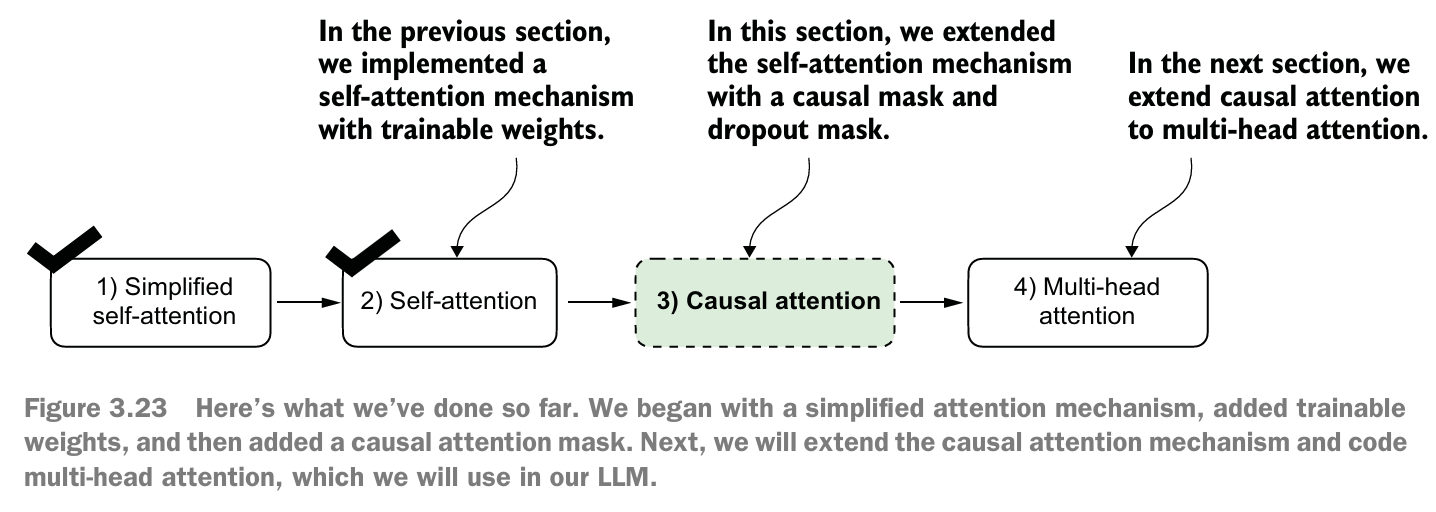

## **6 - Estendendo a Atenção de Uma Única Cabeça para a *Atenção de Várias Cabeças (Multi-Head Attention)***

Nosso passo final será estender a classe de atenção causal implementada anteriormente para múltiplas cabeças. Isso também é chamado de ***atenção multicabeça (multi-head attention)***.

O termo "multicabeça" refere-se à divisão do mecanismo de atenção em múltiplas "cabeças", cada uma operando independentemente. Nesse contexto, um único módulo de atenção causal pode ser considerado atenção de cabeça única, onde há apenas um conjunto de pesos de atenção processando a entrada sequencialmente.

Abordaremos essa expansão da atenção causal para a atenção multicabeça. Primeiro, construiremos intuitivamente um módulo de atenção multicabeça empilhando múltiplos módulos de Atenção Causal. Em seguida, implementaremos o mesmo módulo de atenção multicabeça de uma maneira mais complexa, porém computacionalmente mais eficiente.

### **6.1 - Empilhamento (Stacking) de Múltiplas Camadas de Atenção de Cabeça Única**

Em termos práticos, a implementação da atenção multicabeça envolve a criação de múltiplas instâncias do mecanismo de autoatenção (ver figura 3.18), cada uma com seus próprios pesos, e a combinação de suas saídas. O uso de múltiplas instâncias do mecanismo de autoatenção pode ser computacionalmente intensivo, mas é crucial para o tipo de reconhecimento de padrões complexos pelo qual modelos como os LLMs baseados em transformadores são conhecidos.

A Figura 3.24 ilustra a estrutura de um módulo de atenção multicabeça, que consiste em múltiplos módulos de atenção de uma única cabeça, como mostrado anteriormente na figura 3.18, empilhados uns sobre os outros.

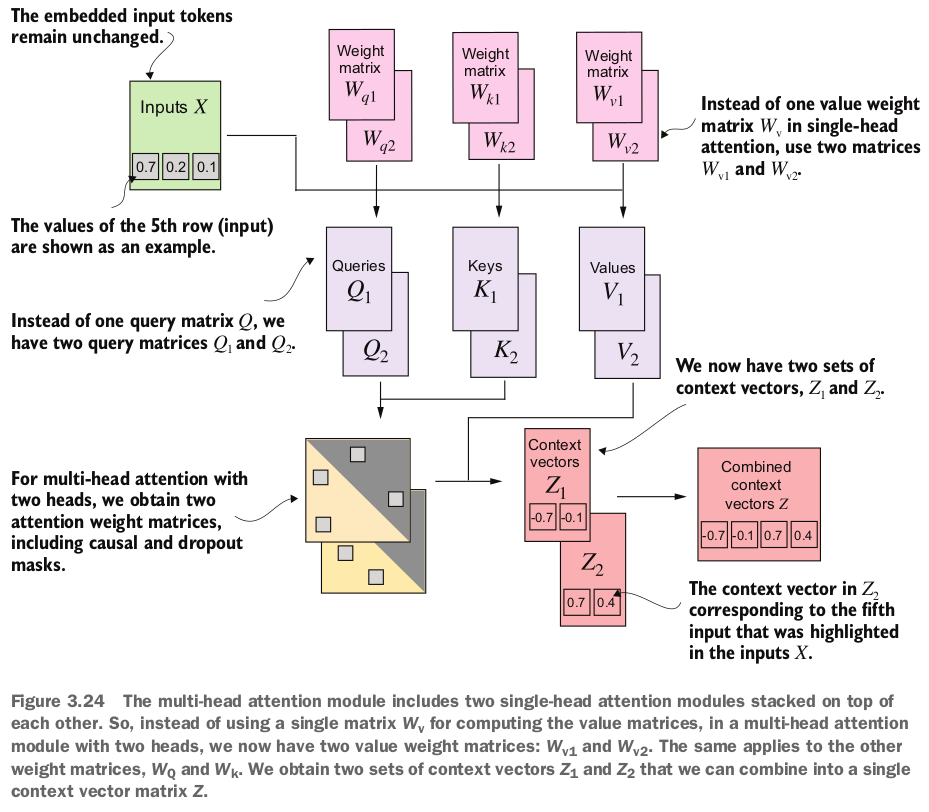

Como mencionado anteriormente, a ideia principal por trás da atenção multicabeça é executar o mecanismo de atenção várias vezes (em paralelo) com diferentes projeções lineares aprendidas — os resultados da multiplicação dos dados de entrada (como os vetores de consulta, chave e valor em mecanismos de atenção) por uma matriz de pesos. Em código, podemos conseguir isso implementando uma classe simples `MultiHeadAttentionWrapper` que empilha múltiplas instâncias do nosso módulo `CausalAttention` implementado anteriormente.

In [ ]:
import torch.nn as nn # Importa o módulo 'nn' do PyTorch, que contém classes e funções
                      # para construir e treinar redes neurais, como camadas, módulos, etc.
                      # 'nn' é essencial para definir a arquitetura de modelos no PyTorch.

# Define uma nova classe chamada 'MultiHeadAttentionWrapper'.
# Esta classe herda de 'nn.Module', a classe base para todos os módulos de rede neural no PyTorch.
# Herdar de nn.Module permite que a classe registre seus parâmetros, sub-módulos,
# e aproveite funcionalidades como mover o modelo para a GPU/CPU e gerenciar o estado.
class MultiHeadAttentionWrapper(nn.Module):

    # Define o método construtor (__init__) da classe.
    # Este método é chamado quando uma nova instância de MultiHeadAttentionWrapper é criada.
    # self: Refere-se à instância atual da classe.
    # d_in: A dimensão de entrada dos embeddings (o tamanho de cada vetor de token na entrada).
    #       Exemplo: se cada palavra for representada por um vetor de 768 dimensões, d_in seria 768.
    # d_out: A dimensão de saída desejada para os vetores de consulta, chave e valor
    #        APÓS a projeção linear dentro de cada cabeça de atenção.
    #        NOTA: A dimensão final de saída do módulo MultiHeadAttentionWrapper será d_out * num_heads.
    # context_length: O comprimento máximo da sequência que esta camada de atenção pode manipular.
    #                 Usado para criar a máscara causal dentro de cada CausalAttention head.
    # dropout: A probabilidade de um elemento (neste caso, um peso de atenção) ser zerado
    #          durante o treinamento (técnica de regularização para evitar overfitting).
    # num_heads: O número de "cabeças" de atenção independentes a serem usadas.
    #            Cada cabeça aprende a prestar atenção a diferentes aspectos dos dados de entrada.
    # qkv_bias: Um parâmetro booleano opcional. Se True, adiciona um termo de viés (bias)
    #           às projeções lineares de query, key e value dentro de cada CausalAttention head.
    #           O padrão é False.
    def __init__(self, d_in, d_out, context_length,
                dropout, num_heads, qkv_bias=False):

        # Chama o construtor da classe pai (nn.Module).
        # É crucial chamar isso primeiro para garantir que a funcionalidade básica de nn.Module
        # seja inicializada corretamente (como registrar parâmetros e buffers).
        super().__init__()

        # Cria uma lista de módulos de atenção causal (as "cabeças").
        # self.heads: Armazena a lista de módulos CausalAttention como um atributo da instância.
        # nn.ModuleList(...): Um contêiner especial no PyTorch que armazena uma lista de nn.Modules.
        #                     É importante usar nn.ModuleList (em vez de uma lista Python normal)
        #                     para que o PyTorch possa registrar corretamente os parâmetros
        #                     de cada módulo CausalAttention (W_query, W_key, W_value, etc.)
        #                     e movê-los para o dispositivo correto (GPU/CPU).
        # [... for _ in range(num_heads)]: Uma compreensão de lista que cria 'num_heads' instâncias
        #                                  da classe CausalAttention.
        # CausalAttention(...): Cria uma instância da camada de atenção causal.
        #                       d_in, d_out, context_length, dropout, qkv_bias: Passa os argumentos
        #                       relevantes do construtor MultiHeadAttentionWrapper para o construtor
        #                       de cada CausalAttention head. Cada cabeça terá suas PRÓPRIAS
        #                       matrizes de pesos W_query, W_key, W_value (e máscara causal compartilhada
        #                       se implementada como buffer na CausalAttention).
        #                       O'_' na compreensão de lista indica que a variável do loop não é usada.
        self.heads = nn.ModuleList(
            [CausalAttention( # Cria uma instância da camada CausalAttention para cada cabeça.
                  d_in, d_out, # Passa as dimensões de entrada e saída para a cabeça.
                  context_length, # Passa o comprimento do contexto para a máscara causal.
                  dropout, # Passa a probabilidade de dropout para a cabeça.
                  qkv_bias # Passa a opção de viés para as projeções QKV.
            )
            for _ in range(num_heads)] # Repete a criação de uma cabeça para o número total de cabeças especificado.
        )

    # Define o método 'forward'.
    # Este método é chamado quando a instância de MultiHeadAttentionWrapper é usada para processar dados.
    # Por exemplo, `output = meu_modulo_mha(input_tensor)` chamaria este método.
    # self: Refere-se à instância atual da classe.
    # x: O tensor de entrada para o módulo MultiHeadAttentionWrapper.
    #    Formato esperado: [tamanho do lote (b), número de tokens (num_tokens), dimensão de entrada (d_in)].
    def forward(self, x):
        # Processa a entrada 'x' através de cada cabeça de atenção na lista 'self.heads'.
        # [head(x) for head in self.heads]: Uma compreensão de lista que itera sobre cada
        #                                  instância 'head' na lista 'self.heads'.
        #                                  Para cada 'head', chama seu método 'forward'
        #                                  passando o tensor de entrada 'x'.
        #                                  Cada chamada 'head(x)' retorna um tensor com o formato
        #                                  [b, num_tokens, d_out], representando os vetores de contexto
        #                                  calculados por aquela cabeça específica para cada token no lote.
        #                                  A compreensão de lista coleta esses tensores de saída
        #                                  em uma lista Python.
        # torch.cat(..., dim=-1): Concatena os tensores na lista de saída da compreensão de lista.
        #                         'dim=-1': Especifica que a concatenação deve ocorrer ao longo
        #                                   da última dimensão dos tensores de entrada.
        #                                   Como cada tensor de saída tem formato [b, num_tokens, d_out],
        #                                   concatenar ao longo da última dimensão ([d_out])
        #                                   resulta em um tensor final com formato
        #                                   [b, num_tokens, d_out * num_heads].
        #                                   Isso combina os vetores de contexto de todas as cabeças
        #                                   para cada token, criando uma representação de maior dimensão.
        return torch.cat( # Concatena os resultados das cabeças.
            [head(x) # Processa a entrada 'x' através de cada cabeça de atenção...
             for head in self.heads], # ...para cada cabeça na lista de cabeças...
             dim=-1 # ...e concatena os resultados ao longo da última dimensão.
        )

# Como interpretar o resultado:
# A saída do método forward é um tensor com formato [tamanho do lote, número de tokens, dimensão final de saída].
# A dimensão final de saída é igual a d_out * num_heads.
# Cada vetor [batch_idx, token_idx, :] neste tensor final é a concatenação dos vetores de contexto
# gerados para o token 'token_idx' do lote 'batch_idx' por cada uma das 'num_heads' cabeças de atenção.
# Cada cabeça de atenção se concentrou em diferentes aspectos ou relações nos dados de entrada,
# e a concatenação dessas representações enriquecidas forma um vetor de contexto mais abrangente
# para cada token, capturando uma gama mais ampla de informações contextuais da sequência.

Por exemplo, se usarmos esta classe `MultiHeadAttentionWrapper` com duas cabeças de atenção (via `num_heads=2`) e a dimensão de saída `CausalAttention` `d_out=2`, obteremos um vetor de contexto de quatro dimensões (`d_out*num_heads=4`), conforme ilustrado na figura 3.25.

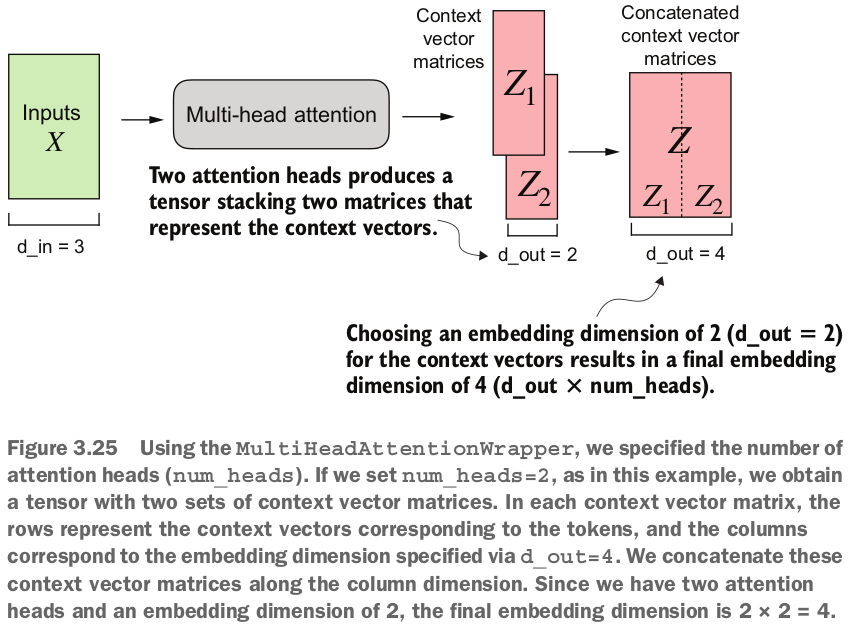

Para ilustrar isso melhor com um exemplo concreto, podemos usar a classe `MultiHeadAttentionWrapper` semelhante à classe `CausalAttention` anterior:

In [ ]:
torch.manual_seed(123)
# Define a semente para o gerador de números aleatórios do PyTorch.
# 'torch.manual_seed(123)': Garante que a inicialização de quaisquer parâmetros aleatórios
#                          (como os pesos nas camadas lineares dentro de CausalAttention, se não
#                           especificado de outra forma) seja a mesma a cada execução com esta semente.
#                          Isso é útil para reprodutibilidade, garantindo que os resultados sejam
#                          consistentes para depuração e comparação.

context_length = batch.shape[1] # This is the number of tokens
# Obtém o comprimento máximo da sequência no lote de entrada.
# 'batch': O tensor de entrada que representa um lote de sequências (formato [tamanho do lote, número de tokens, dimensão do embedding]).
# 'batch.shape': Retorna uma tupla representando as dimensões do tensor 'batch'.
# '[1]': Acessa o segundo elemento da tupla de forma, que corresponde ao número de tokens (comprimento da sequência) em cada sequência dentro do lote.
# 'context_length': Armazena esse número. Este valor será usado para definir o tamanho da máscara causal dentro da classe CausalAttention.

d_in, d_out = 3, 2
# Define as dimensões de entrada e saída para o módulo de atenção multicabeças.
# 'd_in = 3': A dimensão de entrada dos embeddings, conforme definido anteriormente no notebook ( embeddings tridimensionais).
# 'd_out = 2': A dimensão de saída desejada para os vetores de consulta, chave e valor APÓS a projeção linear DENTRO de cada cabeça de atenção individual.
#              NOTA: A dimensão de saída FINAL do módulo MultiHeadAttentionWrapper será d_out * num_heads.

mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)
# Cria uma instância da classe MultiHeadAttentionWrapper.
# 'MultiHeadAttentionWrapper(...)': Chama o construtor (__init__) da classe MultiHeadAttentionWrapper.
# 'd_in': Passa a dimensão de entrada dos embeddings (3) para o construtor.
# 'd_out': Passa a dimensão de saída desejada para CADA cabeça de atenção (2) para o construtor.
# 'context_length': Passa o comprimento máximo da sequência para o construtor. Isso será usado pelas cabeças CausalAttention internas para criar a máscara causal.
# '0.0': Passa a probabilidade de dropout (0.0, desabilitado) para o construtor.
# 'num_heads=2': Especifica que o módulo deve ter 2 cabeças de atenção independentes. O construtor criará 2 instâncias de CausalAttention.
# 'mha': A variável que armazena a instância criada do módulo de atenção multicabeças.

context_vecs = mha(batch)
# Passa o lote de entrada 'batch' através da instância MultiHeadAttentionWrapper.
# 'mha(batch)': Chama o método forward da instância 'mha', passando o tensor 'batch' como entrada.
#              O método forward executa o seguinte:
#              1. Itera sobre cada uma das 2 cabeças CausalAttention dentro de 'mha'.
#              2. Para cada cabeça, chama seu método forward com 'batch'. Cada cabeça calcula vetores de contexto [tamanho do lote, num_tokens, d_out].
#              3. Concatena os vetores de contexto de todas as cabeças ao longo da última dimensão.
#                 Como cada cabeça retorna [b, num_tokens, d_out] e temos 2 cabeças, a concatenação resulta em um tensor de formato [b, num_tokens, d_out * 2], ou seja, [b, num_tokens, 4].
# 'context_vecs': Armazena o tensor resultante, que são os vetores de contexto combinados para cada token em cada sequência do lote.

print(context_vecs)
# Imprime o tensor 'context_vecs' no console.
# Este tensor contém os vetores de contexto de saída para cada token em cada sequência do lote,
# onde cada vetor de contexto é a concatenação das saídas das 2 cabeças de atenção.
# Sua forma será [tamanho do lote, número de tokens, dimensão de saída final (d_out * num_heads)].

print("\ncontext_vecs.shape:", context_vecs.shape)
# Imprime a string "context_vecs.shape:" seguida da forma (dimensões) do tensor 'context_vecs'.
# 'context_vecs.shape': Retorna uma tupla representando as dimensões do tensor 'context_vecs'.
#                       Para este exemplo específico, com batch.shape = [2, 6, 3] e d_out=2, num_heads=2,
#                       a forma esperada é torch.Size([2, 6, 4]).
#                       Este print confirma o formato da saída do módulo MultiHeadAttentionWrapper.

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)

context_vecs.shape: torch.Size([2, 6, 4])


A primeira dimensão do tensor `context_vecs` resultante é 2, pois temos dois textos de entrada (os textos de entrada são duplicados, razão pela qual os vetores de contexto são exatamente os mesmos para eles). A segunda dimensão refere-se aos 6 tokens em cada entrada. A terceira dimensão refere-se à incorporação quadridimensional de cada token.

---

$\large \textbf{Exercício 3.2 Retornando vetores de embedding bidimensionais}$

Altere os argumentos de entrada para a chamada `MultiHeadAttentionWrapper(..., num_heads=2)` de forma que os vetores de contexto de saída sejam bidimensionais em vez de quadridimensionais, mantendo a configuração `num_heads=2`. Dica: você não precisa modificar a implementação da classe; basta alterar um dos outros argumentos de entrada.

---

Até este ponto, implementamos um `MultiHeadAttentionWrapper` que combinava
vários módulos de atenção de uma única cabeça. No entanto, estes são processados sequencialmente via `[head(x) for head in self.heads]` no método forward. Podemos melhorar esta implementação processando as cabeças em paralelo. Uma maneira de conseguir isso é calcular as saídas para todas as cabeças de atenção simultaneamente por meio da multiplicação de matrizes.

### **6.2 - Implementando Atenção Multi-Cabeça (Multi-head Attention) com Divisão de Peso**

Até agora, criamos um `MultiHeadAttentionWrapper` para implementar a atenção multicabeçal, empilhando vários módulos de atenção de cabeça única. Isso foi feito instanciando e combinando vários objetos `CausalAttention`.

Em vez de manter duas classes separadas, `MultiHeadAttentionWrapper` e
`CausalAttention`, podemos combinar esses conceitos em uma única classe `MultiHeadAttention`. Além de mesclar o `MultiHeadAttentionWrapper` com o código `Causal-Attention`, faremos algumas outras modificações para implementar a atenção multicabeçal de forma mais eficiente.

No `MultiHeadAttentionWrapper`, múltiplas cabeças são implementadas criando
uma lista de objetos `CausalAttention` (`self.heads`), cada um representando uma cabeça de atenção separada. A classe CausalAttention executa o mecanismo de atenção de forma independente, e os resultados de cada cabeça são concatenados. Em contraste, a classe `MultiHeadAttention` a seguir integra a funcionalidade de múltiplos cabeçalhos em uma única classe. Ela divide a entrada em vários cabeçalhos, remodelando os tensores projetados de consulta, chave e valor
e, em seguida, combina os resultados desses cabeçalhos após calcular a atenção.

Vamos dar uma olhada na classe `MultiHeadAttention` antes de discuti-la mais detalhadamente.

In [ ]:
class MultiHeadAttention(nn.Module):
    # Construtor da classe MultiHeadAttention.
    # Inicializa os componentes necessários para o mecanismo de atenção multi-cabeças.
    def __init__(self, d_in, d_out,
                context_length, dropout, num_heads, qkv_bias=False):
        # Chama o construtor da classe base (nn.Module).
        # É essencial para que o PyTorch registre corretamente os módulos.
        super().__init__()

        # Afirmação para garantir que d_out (dimensão de saída) é divisível por num_heads (número de cabeças de atenção).
        # Isso é crucial porque a dimensão de saída será dividida igualmente entre as cabeças.
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        # Armazena a dimensão de saída da atenção.
        self.d_out = d_out
        # Armazena o número de cabeças de atenção.
        self.num_heads = num_heads
        # Calcula a dimensão de cada "cabeça" individual.
        # d_out é dividido igualmente entre as num_heads.
        self.head_dim = d_out // num_heads

        # Camada linear para transformar as entradas em "queries" (consultas).
        # d_in é a dimensão de entrada, d_out é a dimensão de saída.
        # qkv_bias=False indica se a camada linear terá um termo de bias.
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Camada linear para transformar as entradas em "keys" (chaves).
        # As chaves são usadas para calcular a similaridade com as queries.
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Camada linear para transformar as entradas em "values" (valores).
        # Os valores são as informações que serão ponderadas pelas pontuações de atenção.
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Camada linear final que projeta a concatenação das saídas de todas as cabeças de atenção de volta para d_out.
        self.out_proj = nn.Linear(d_out, d_out)
        # Camada de Dropout para regularização.
        # Ajuda a prevenir o overfitting, zerando aleatoriamente algumas ativações.
        self.dropout = nn.Dropout(dropout)

        # Registra um buffer não treinável chamado "mask".
        # Buffers são tensores que fazem parte do estado do módulo, mas não são parâmetros treináveis.
        # torch.triu cria uma matriz triangular superior.
        # torch.ones cria uma matriz de uns com as dimensões context_length x context_length.
        # diagonal=1 significa que a diagonal principal e tudo abaixo dela será zero,
        # e tudo acima da diagonal principal será um.
        # Isso é usado para a máscara de atenção, especialmente em decodificadores,
        # para evitar que um token atenda a tokens futuros.
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                      diagonal=1).bool() # Convertido para booleano para masked_fill_
        )

    # Método forward define a passagem para frente do modelo.
    # É onde a lógica principal da atenção multi-cabeças é implementada.
    def forward(self, x):
        # Desempacota as dimensões do tensor de entrada x.
        # b: tamanho do batch (número de sequências no batch).
        # num_tokens: número de tokens (ou elementos) em cada sequência.
        # d_in: dimensão de entrada de cada token.
        b, num_tokens, d_in = x.shape

        # Aplica a camada linear W_key à entrada x para obter as chaves.
        # keys.shape será (b, num_tokens, d_out).
        keys = self.W_key(x)
        # Aplica a camada linear W_query à entrada x para obter as consultas.
        # queries.shape será (b, num_tokens, d_out).
        queries = self.W_query(x)
        # Aplica a camada linear W_value à entrada x para obter os valores.
        # values.shape será (b, num_tokens, d_out).
        values = self.W_value(x)

        # Remodela as chaves, valores e consultas para incluir a dimensão num_heads.
        # A dimensão d_out é dividida em num_heads e head_dim.
        # keys.view transforma (b, num_tokens, d_out) em (b, num_tokens, num_heads, head_dim).
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(
            b, num_tokens, self.num_heads, self.head_dim
        )

        # Transpõe as dimensões 1 e 2 para que num_heads venha antes de num_tokens.
        # Isso organiza os tensores para que a operação de atenção possa ser feita em paralelo para cada cabeça.
        # Agora, a dimensão das chaves, consultas e valores será (b, num_heads, num_tokens, head_dim).
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Calcula as pontuações de atenção (attention scores).
        # É o produto escalar das consultas e das chaves transpostas.
        # queries.shape é (b, num_heads, num_tokens, head_dim).
        # keys.transpose(2, 3) inverte as duas últimas dimensões de keys, tornando-o (b, num_heads, head_dim, num_tokens).
        # O resultado é attn_scores.shape (b, num_heads, num_tokens, num_tokens).
        # Cada elemento [i, j, k, l] representa a pontuação de similaridade entre o k-ésimo token da consulta
        # e o l-ésimo token da chave, para a i-ésima amostra do batch e a j-ésima cabeça.
        attn_scores = queries @ keys.transpose(2, 3)

        # Extrai a parte relevante da máscara registrada.
        # A máscara é cortada para corresponder ao número atual de tokens.
        # mask_bool será uma matriz booleana (num_tokens, num_tokens).
        mask_bool = self.mask[:num_tokens, :num_tokens]

        # Aplica a máscara às pontuações de atenção.
        # O método masked_fill_ preenche os elementos onde mask_bool é True com -torch.inf (menos infinito).
        # Isso garante que, após a aplicação da função softmax, esses elementos se tornem zero,
        # efetivamente impedindo que um token "olhe" para tokens futuros (em casos de atenção causal).
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # Calcula os pesos de atenção (attention weights).
        # Divide as pontuações de atenção pela raiz quadrada da dimensão da cabeça (head_dim**0.5).
        # Isso é conhecido como "scaling" e ajuda a evitar que o produto escalar se torne muito grande,
        # o que poderia empurrar os gradientes para regiões com gradientes muito pequenos na função softmax.
        # Em seguida, aplica a função softmax ao longo da última dimensão (dim=-1).
        # O softmax transforma as pontuações em probabilidades, somando 1 ao longo da dimensão dos tokens.
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        # Aplica dropout aos pesos de atenção para regularização.
        attn_weights = self.dropout(attn_weights)

        # Calcula o vetor de contexto (context vector).
        # É o produto matricial dos pesos de atenção e dos valores.
        # attn_weights.shape é (b, num_heads, num_tokens, num_tokens).
        # values.shape é (b, num_heads, num_tokens, head_dim).
        # O resultado (attn_weights @ values) tem a forma (b, num_heads, num_tokens, head_dim).
        # Cada linha na dimensão num_tokens é uma soma ponderada dos valores, onde os pesos
        # são dados pelos pesos de atenção.
        # .transpose(1, 2) reorganiza as dimensões de volta para (b, num_tokens, num_heads, head_dim).
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Remodela o vetor de contexto para concatenar as saídas de todas as cabeças.
        # .contiguous() garante que o tensor esteja armazenado de forma contígua na memória,
        # o que é necessário para a operação .view().
        # Transforma (b, num_tokens, num_heads, head_dim) de volta para (b, num_tokens, d_out).
        # Basicamente, junta as saídas de todas as cabeças de atenção.
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        # Aplica a camada de projeção de saída (out_proj) ao vetor de contexto.
        # Isso permite que o modelo aprenda uma transformação final sobre a informação combinada de todas as cabeças.
        context_vec = self.out_proj(context_vec)
        # Retorna o vetor de contexto final, que representa a informação agregada de atenção.
        return context_vec

Embora a remodelação (`.view`) e a transposição (`.transpose`) de tensores dentro da classe `MultiHeadAttention` pareçam muito complicadas matematicamente, a classe `MultiHeadAttention` implementa o mesmo conceito que o `MultiHeadAttentionWrapper` anterior.

Em um nível mais amplo, no `MultiHeadAttentionWrapper` anterior, empilhamos várias camadas de atenção de cabeça única que combinamos em uma camada de atenção de múltiplas cabeças. A classe `MultiHeadAttention` adota uma abordagem integrada. Ela começa com uma camada de múltiplas cabeças e, em seguida, divide internamente essa camada em cabeças de atenção individuais, conforme ilustrado na figura 3.26.

A divisão dos tensores de consulta, chave e valor é obtida por meio de operações de remodelação e transposição de tensores usando os métodos `.view` e `.transpose` do PyTorch. A entrada é primeiro transformada (por meio de camadas lineares para consultas, chaves e valores) e, em seguida, remodelada para representar múltiplas cabeças.

A operação principal é dividir a dimensão `d_out` em `num_heads` e `head_dim`,
onde `head_dim = d_out / num_heads`. Essa divisão é então realizada usando o método `.view`: um tensor de dimensões (`b, num_tokens, d_out`) é remodelado para a dimensão (`b, num_tokens, num_heads, head_dim`).

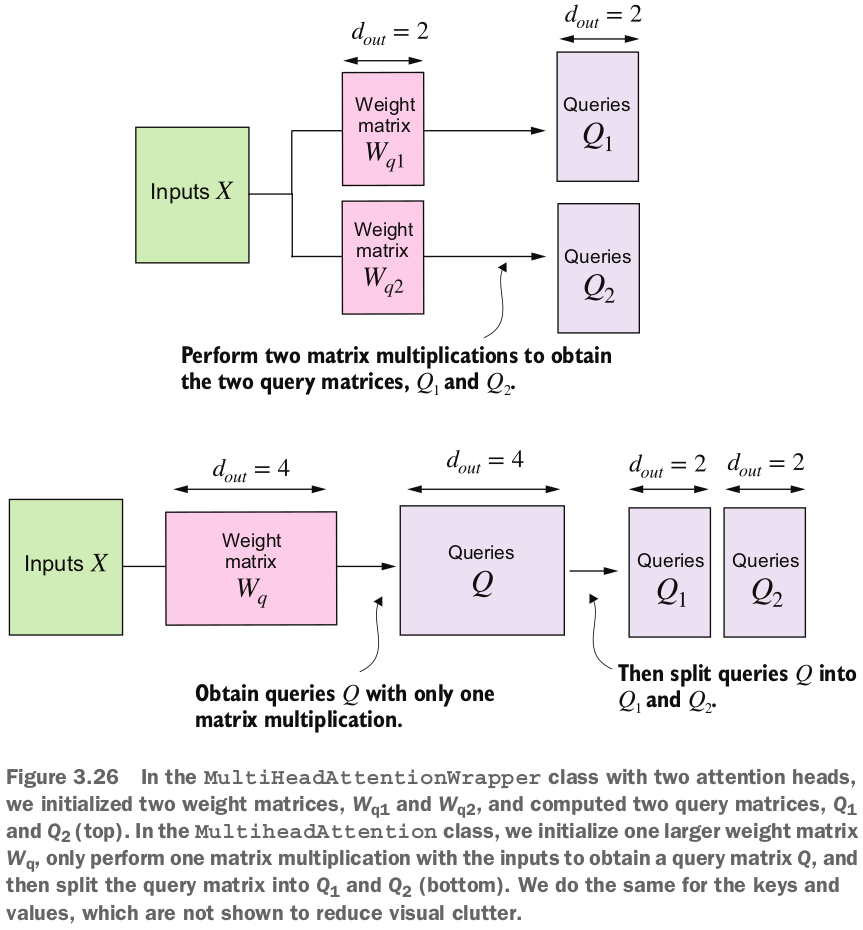

Os tensores são então transpostos para trazer a dimensão `num_heads` antes da dimensão `num_tokens`, resultando em um formato de (`b, num_heads, num_tokens, head_dim`). Essa transposição é crucial para alinhar corretamente as consultas, chaves e valores entre as diferentes cabeças e realizar multiplicações de matrizes em lote com eficiência.

Para ilustrar essa multiplicação de matrizes em lote, suponha que temos o seguinte
tensor:

In [ ]:
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

In [ ]:
a.shape

torch.Size([1, 2, 3, 4])

Agora realizamos uma multiplicação de matriz em lote entre o próprio tensor e uma visualização do tensor onde transpusemos as duas últimas dimensões, `num_tokens` e `head_dim`:

In [ ]:
# Realiza a multiplicação de matrizes em lote e imprime o resultado.
# 'a': Este é o tensor de entrada original (formato [b, num_heads, num_tokens, head_dim]),
#      onde 'b' é o tamanho do lote (1 neste caso), 'num_heads' é o número de cabeças (2 neste caso),
#      'num_tokens' é o número de tokens (3 neste caso), e 'head_dim' é a dimensão da cabeça (4 neste caso).
# '@': Este é o operador de multiplicação de matrizes no PyTorch.
# 'a.transpose(2, 3)': Calcula a transposta do tensor 'a' trocando as dimensões com índice 2 e 3.
#                      Originalmente, 'a' tem o formato (b, num_heads, num_tokens, head_dim).
#                      Após a transposição, o formato se torna (b, num_heads, head_dim, num_tokens).
#                      Neste exemplo específico, o formato de 'a' é (1, 2, 3, 4).
#                      A transposta 'a.transpose(2, 3)' terá o formato (1, 2, 4, 3).
#
# A operação 'a @ a.transpose(2, 3)' realiza uma multiplicação de matrizes em lote.
# O PyTorch interpreta essa operação da seguinte forma:
# - Ele mantém as primeiras dimensões (batch e num_heads) fixas.
# - Ele realiza a multiplicação de matrizes nas duas últimas dimensões.
#   Ou seja, para cada combinação de índices nas dimensões batch e num_heads, ele multiplica a sub-matriz
#   'a[b_idx, head_idx, :, :]' (formato [num_tokens, head_dim])
#   pela sub-matriz transposta 'a.transpose(2, 3)[b_idx, head_idx, :, :]' (formato [head_dim, num_tokens]).
#   A multiplicação de uma matriz [num_tokens, head_dim] por uma matriz [head_dim, num_tokens]
#   resulta em uma matriz [num_tokens, num_tokens].
# - O resultado da multiplicação de matrizes em lote é um novo tensor com o formato (b, num_heads, num_tokens, num_tokens).
#   Neste exemplo, o formato resultante é (1, 2, 3, 3).
#
# Esta operação é matematicamente equivalente a calcular o produto escalar entre
# cada vetor de "consulta" (linha na sub-matriz original) e cada vetor de "chave"
# (linha na sub-matriz original, que se torna uma coluna na transposta).
# É o mesmo cálculo das pontuações de atenção (attn_scores) quando consultas e chaves são projetadas para o mesmo espaço.
print(a @ a.transpose(2, 3), 2*'\n',
      (a @ a.transpose(2, 3)).shape)

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]]) 

 torch.Size([1, 2, 3, 3])


Neste caso, a implementação da multiplicação de matrizes no PyTorch manipula o tensor de entrada quadridimensional para que a multiplicação da matriz seja realizada entre as duas últimas dimensões (`num_tokens, head_dim`) e, em seguida, repetida para as cabeças individuais.

Por exemplo, o procedimento anterior torna-se uma maneira mais compacta de calcular a multiplicação da matriz para cada cabeça separadamente:

In [ ]:
first_head = a[0, 0, :, :]
# Seleciona uma "cabeça" específica do tensor 'a'.
# 'a': O tensor original com a forma [b, num_heads, num_tokens, head_dim]. Neste exemplo, a.shape é (1, 2, 3, 4).
# '[0, 0, :, :]': Indexa o tensor 'a'.
#                '[0]': Seleciona o primeiro elemento na dimensão do batch (índice 0).
#                '[0]': Seleciona o primeiro elemento na dimensão das cabeças (índice 0).
#                '[:, :]': Seleciona todas as linhas e colunas das duas últimas dimensões (num_tokens e head_dim).
# O resultado 'first_head' é um tensor com a forma das duas últimas dimensões originais: [num_tokens, head_dim].
# Neste exemplo, first_head.shape será (3, 4). Representa os dados de uma única cabeça de atenção para uma única amostra do lote.

first_res = first_head @ first_head.T
# Calcula o produto matricial entre 'first_head' e sua transposta.
# 'first_head': O tensor selecionado acima, com a forma [num_tokens, head_dim] (neste caso, (3, 4)).
# '@': O operador de multiplicação de matrizes no PyTorch.
# 'first_head.T': Calcula a transposta do tensor 'first_head'. Isso troca suas dimensões, resultando em um tensor com a forma [head_dim, num_tokens] (neste caso, (4, 3)).
# A multiplicação de uma matriz [num_tokens, head_dim] por uma matriz [head_dim, num_tokens] resulta em uma matriz [num_tokens, num_tokens].
# Neste caso, first_res.shape será (3, 3).
# Esta operação calcula o produto escalar entre cada linha de 'first_head' e cada linha de 'first_head' (que se tornam colunas em first_head.T).
# Isso é equivalente ao cálculo das pontuações de atenção para esta única cabeça.

print("First head:\n", first_res)

second_head = a[0, 1, :, :]
# Seleciona a SEGUNDA "cabeça" do tensor 'a' (índice 1 na dimensão das cabeças).
# 'a': O tensor original com a forma [b, num_heads, num_tokens, head_dim] (neste exemplo, (1, 1, 3, 4)).
#      NOTA: O tensor 'a' neste exemplo específico só tem 1 cabeça (índice 0). Acessar o índice 1 aqui causaria um erro de índice em um cenário real com este tensor 'a'.
#      Presumindo que 'a' tivesse shape (1, 2, 3, 4) para este exemplo fazer sentido:
#      '[0]': Seleciona o primeiro elemento na dimensão do batch (índice 0).
#      '[1]': Seleciona o SEGUNDO elemento na dimensão das cabeças (índice 1).
#      '[:, :]': Seleciona todas as linhas e colunas das duas últimas dimensões (num_tokens e head_dim).
# O resultado 'second_head' seria um tensor com a forma [num_tokens, head_dim], representando os dados da segunda cabeça para a mesma amostra do lote.

second_res = second_head @ second_head.T
# Calcula o produto matricial entre 'second_head' e sua transposta.
# Similar ao cálculo de 'first_res', mas usando os dados da segunda cabeça.
# 'second_head': O tensor selecionado acima, com a forma [num_tokens, head_dim].
# '@': O operador de multiplicação de matrizes.
# 'second_head.T': A transposta de 'second_head', com a forma [head_dim, num_tokens].
# O resultado 'second_res' é uma matriz [num_tokens, num_tokens] que contém as pontuações de similaridade entre cada par de tokens, mas da perspectiva da segunda cabeça de atenção.

print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


Os resultados são exatamente os mesmos que obtivemos ao usar a multiplicação de matrizes em lote `print(a @ a.transpose(2, 3))`.

Continuando com `MultiHeadAttention`, após calcular os pesos de atenção e os vetores de contexto, os vetores de contexto de todas as cabeças são transpostos de volta para a forma (`b, num_tokens, num_heads, head_dim`). Esses vetores são então remodelados (achatados) para a forma (`b, num_tokens, d_out`), combinando efetivamente as saídas de todas as cabeças.

Além disso, adicionamos uma camada de projeção de saída (`self.out_proj`) a `MultiHeadAttention` após combinar as cabeças, o que não está presente na classe `CausalAttention`. Essa camada de projeção de saída não é estritamente necessária (consulte o apêndice B para mais detalhes), mas é comumente usada em muitas arquiteturas de LLM, e é por isso que a adicionei aqui para fins de completude.

Embora a classe `MultiHeadAttention` pareça mais complexa que a `MultiHeadAttentionWrapper` devido à remodelagem e transposição adicionais de
tensores, ela é mais eficiente. Isso ocorre porque precisamos apenas de uma multiplicação de matrizes para calcular as chaves, por exemplo, `keys = self.W_key(x)` (o mesmo se aplica às consultas e valores). Na classe `MultiHeadAttentionWrapper`, precisamos repetir essa multiplicação de matrizes, que é computacionalmente uma das etapas mais custosas, para cada cabeça de atenção.

A classe `MultiHeadAttention` pode ser usada de forma semelhante às classes `SelfAttention` e `CausalAttention` que implementamos anteriormente:

In [ ]:
torch.manual_seed(123)
# Define a semente para o gerador de números aleatórios do PyTorch.
# 'torch.manual_seed(123)': Garante que a inicialização de quaisquer parâmetros aleatórios
#                          (como os pesos nas camadas lineares dentro de MultiHeadAttention)
#                          seja a mesma a cada execução com esta semente.
#                          Isso é útil para reprodutibilidade, garantindo que os resultados sejam
#                          consistentes para depuração e comparação, especialmente em experimentos.

batch_size, context_length, d_in = batch.shape
# Desempacota as dimensões do tensor de entrada 'batch'.
# 'batch': O tensor de entrada que representa um lote de sequências. Sua forma atual é (tamanho do lote, número de tokens, dimensão do embedding).
# '.shape': Retorna uma tupla contendo as dimensões do tensor 'batch'.
# 'batch_size, context_length, d_in = ...': Atribui os elementos da tupla de forma a variáveis separadas.
#                                       'batch_size': Irá armazenar o tamanho do lote.
#                                       'context_length': Irá armazenar o número de tokens em cada sequência (o comprimento da sequência).
#                                       'd_in': Irá armazenar a dimensão de entrada dos embeddings (o tamanho do vetor para cada token).
# Isso é útil para obter dinamicamente as dimensões necessárias para inicializar a camada de atenção.

d_out = 2
# Define a dimensão de saída desejada para o *módulo MultiHeadAttention*.
# 'd_out = 2': Neste exemplo, estamos definindo que a dimensão final de saída para cada token
#              após passar pela camada MultiHeadAttention será 2.
#              É importante notar que esta 'd_out' é a dimensão final, que pode ser
#              diferente da dimensão de saída *por cabeça* ('head_dim'). A relação é
#              d_out (final) = head_dim * num_heads.

mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
# Cria uma instância da classe MultiHeadAttention.
# 'MultiHeadAttention(...)': Chama o construtor (__init__) da classe MultiHeadAttention.
# 'd_in': Passa a dimensão de entrada dos embeddings (obtida de batch.shape[2], 3 neste caso) para o construtor.
# 'd_out': Passa a dimensão de saída final desejada (2 neste caso) para o construtor.
#          O construtor usará esta 'd_out' e 'num_heads' para calcular a dimensão de cada cabeça individual ('head_dim').
# 'context_length': Passa o comprimento máximo da sequência (obtido de batch.shape[1], 6 neste caso). Isso é usado para criar a máscara causal dentro da classe.
# '0.0': Passa a probabilidade de dropout (0.0, desabilitado) para o construtor.
# 'num_heads=2': Especifica que o módulo deve ter 2 cabeças de atenção independentes. O construtor calculará 'head_dim = d_out / num_heads = 2 / 2 = 1'. Cada cabeça operará em vetores de dimensão 1.
# 'mha': A variável que armazena a instância criada do módulo de atenção multi-cabeças. Esta instância está pronta para processar dados.

context_vecs = mha(batch)
# Passa o lote de entrada 'batch' através da instância MultiHeadAttention.
# 'mha(batch)': Quando uma instância de um módulo nn.Module é chamada como uma função, seu método 'forward' é executado.
#              Portanto, esta linha chama o método 'forward' da instância 'mha', passando o tensor 'batch' como entrada.
#              O método 'forward' dentro de 'MultiHeadAttention' executa a lógica completa da atenção multi-cabeças:
#              1. Projeta os embeddings de entrada em Q, K, V usando as camadas lineares (self.W_query, self.W_key, self.W_value). Os resultados terão dimensão 'd_out' (2 neste caso) na última dimensão.
#              2. Remodela e transpõe Q, K, V para separar as cabeças de atenção (formato [b, num_heads, num_tokens, head_dim]).
#              3. Calcula as pontuações de atenção (Q @ K.T) para cada cabeça em lote.
#              4. Aplica a máscara causal e o escalonamento (divisão por sqrt(head_dim)) às pontuações.
#              5. Aplica softmax para obter os pesos de atenção normalizados.
#              6. Aplica dropout aos pesos de atenção (desabilitado neste caso p=0.0).
#              7. Calcula os vetores de contexto ponderando os valores pelos pesos de atenção (attn_weights @ values).
#              8. Transpõe e remodela os vetores de contexto de volta para combinar as cabeças (formato [b, num_tokens, d_out]).
#              9. Aplica a camada de projeção de saída (self.out_proj) aos vetores de contexto combinados.
# 'context_vecs': Armazena o tensor resultante da operação forward, que são os vetores de contexto
#                 para cada token em cada sequência do lote, após a atenção multi-cabeças.
#                 Sua forma final será [tamanho do lote, número de tokens, d_out (final)].

print(context_vecs, 2*'\n')
# Imprime o tensor 'context_vecs' no console.
# Este tensor mostra os vetores de contexto resultantes.
# Cada linha na segunda dimensão ([batch_idx, token_idx, :]) é o vetor de contexto para o token
# correspondente, representando sua informação contextualizada após passar pela camada de atenção.
# A dimensão final de cada vetor de contexto é 'd_out' (2 neste caso).

print("context_vecs.shape:", context_vecs.shape)
# Imprime a string "context_vecs.shape:" seguida da forma (dimensões) do tensor 'context_vecs'.
# 'context_vecs.shape': Retorna uma tupla representando as dimensões do tensor 'context_vecs'.
#                       Para este exemplo, com batch.shape = [2, 6, 3], d_out=2 e num_heads=2,
#                       a forma esperada é torch.Size([2, 6, 2]).
#                       Este print confirma o formato da saída do módulo MultiHeadAttention.

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>) 


context_vecs.shape: torch.Size([2, 6, 2])


Os resultados mostram que a dimensão de saída é controlada diretamente pelo argumento `d_out`.

Agora implementamos a classe MultiHeadAttention que usaremos ao implementar e treinar o LLM. Observe que, embora o código seja totalmente funcional, utilizei tamanhos de embedding e números de cabeças de atenção relativamente pequenos para manter as saídas legíveis.

Para efeito de comparação, o menor modelo GPT-2 (117 milhões de parâmetros) possui 12 cabeças de atenção e um tamanho de incorporação do vetor de contexto de 768. O maior modelo GPT-2 (1,5 bilhão de parâmetros) possui 25 cabeças de atenção e um tamanho de incorporação do vetor de contexto de 1.600. Os tamanhos de incorporação das entradas de token e dos embeddings de contexto são os mesmos nos modelos GPT (`d_in = d_out`).

---

$\large \textbf{Exercício 3.3 Inicializando modulos de atencao de tamanho GPT-2}$

Usando a classe `MultiHeadAttention`, inicialize um módulo de atenção multicabeças que tenha o mesmo número de cabeças de atenção que o menor modelo GPT-2 (12 cabeças de atenção). Certifique-se também de usar os respectivos tamanhos de incorporação de entrada e saída, semelhantes ao GPT-2 (768 dimensões). Observe que o menor modelo GPT-2 suporta um comprimento de contexto de 1.024 tokens.

---